## Used to create plots & perform analysis of output produced by model based on dose variations
- Output data will be saved as files and then imported here to analyse/plot.

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import pandas as pd

mystyle = r'https://gist.githubusercontent.com/mbolt01/3087dffd11e70eccb08fdcf327374a5c/raw/std_fig'
plt.style.use(mystyle)

## can do my modelling in this notebook too.
import TCP_NTCP as model

In [261]:
## for reloading a module.
import importlib
importlib.reload(model)

<module 'TCP_NTCP' from 'C:\\Users\\Matt\\OneDrive\\PhD\\Quasar Shared\\Documents\\Thesis\\Corrections\\Code\\Thesis_code_corrections\\TCP_NTCP.py'>

In [2]:
## functions to simply save and load files for use aftger producing modelling results

def save_pkl(obj,filename):
    pickle.dump(obj,open(filename,'wb'))

def load_pkl(filename):
    return pickle.load(open(filename,'rb'))

## example save:
#save_pkl(prost_10year,'test3.pkl')
## example load:
#newtest = load_pkl('test3.pkl')


## define colours to use for each type
color_p = 'C0'
color_hn_conf = 'C1'
color_hn_imrt = 'C2'

marker_p = 'o'
marker_hn_conf = 's'
marker_hn_imrt = '^'

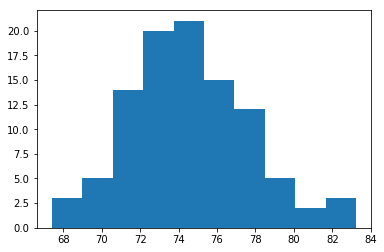

4.05170345337 % sd


In [3]:
## doses to be used for simulations - get 3 lists of absolute dose values

## import the PARSPORT dosimetric stats
df = pd.read_csv(r'parsport_dose_data-edit.csv',index_col=0)


## parotid mean doses for imrt and conformal plans
par_imrt = df[(df['struct_label'].isin(['l_parotid','r_parotid'])) & (df['Type']=='IMRT')]['mean_val'].tolist()
par_conf = df[(df['struct_label'].isin(['l_parotid','r_parotid'])) & (df['Type']=='Conformal')]['mean_val'].tolist()
#plt.boxplot([par_imrt,par_conf],whis=[5,95],showfliers=False)
#plt.show()

## rectal max = generate from conformal PARSPORT PTV1 max doses - assume it abutts
ptv1_max = df[(df['struct_label']=='ptv1') & (df['Type']=='Conformal')]['max_val'].tolist()
ptv1_sd_perc = 100*np.std(ptv1_max)/np.mean(ptv1_max)
ptv1_sd_perc

## generate 100 rectal max doses
#rect = np.random.normal(loc=74,scale=74*0.04,size=100)
#print(100*np.std(rect)/np.mean(rect))

## use these saved values throughout for consistency between plots and comparisons
rect = [75.4628254465,73.3183214907 ,75.3003188187 ,71.3529080173 ,71.6550934465 ,
72.6265454223 ,76.7525163632 ,75.0705614433 ,75.4362902077 ,74.0263880454 ,
78.4267323082 ,72.3140236546 ,69.8988295772 ,68.9674458087 ,73.4091228531 ,
73.6303803205 ,77.7710871266 ,76.2303957683 ,78.5393948303 ,75.1458466771 ,
79.1852359284 ,71.6130975172 ,78.9148705719 ,71.0292489347 ,75.0695034942 ,
77.7488475324 ,75.1088411194 ,74.2115180529 ,83.2385945229 ,80.3738086983 ,
71.5377726415 ,73.7810279543 ,81.9006591441 ,76.7118415001 ,71.2075872837 ,
72.4788669903 ,75.9098291075 ,76.9075004997 ,77.9370203093 ,76.0376426665 ,
81.353333813 ,73.7097073713 ,72.6646630934 ,72.9648074429 ,72.4989630159 ,
75.0775747693 ,72.8740700959 ,71.793738443 ,78.3360492565 ,70.2908240492 ,
75.7242512111 ,71.4394703766 ,75.7519665462 ,78.7449311745 ,71.7900669548 ,
72.9867966457 ,78.8628687724 ,72.5620231996 ,74.9903462013 ,73.8106812105 ,
76.8674559441 ,75.017451569 ,72.3645463208 ,74.765883519 ,76.2708266662 ,
72.111937664 ,74.0780150346 ,72.8801384949 ,76.6324130417 ,72.1612862869 ,
73.6704155001 ,73.3373674291 ,67.4029200226 ,75.1608376668 ,76.9833947022 ,
74.1233227937 ,68.9363843917 ,70.5383235822 ,77.6308749465 ,77.0547032247 ,
75.1896895846 ,75.5107014996 ,77.7498280681 ,75.2386267741 ,71.8985553369 ,
75.4257715235 ,77.377700004 ,70.5474804283 ,71.7401300781 ,69.1618761911 ,
77.44502738 ,71.3132527759 ,73.6496832389 ,74.3419715418 ,81.9218604716 ,
73.5416227025 ,74.4092563046 ,70.8221432609 ,73.8112149224 ,75.6303722485 ]

plt.hist(rect)
plt.show()
print(100*np.std(rect)/np.mean(rect),'% sd')

In [4]:
df.columns

Index(['sub_dir', 'patient_id', 'plan_name', 'struct_label', 'structure',
       'v107', 'v103', 'd5cc', 'v99', 'v105', 'min', 'd0.2cc', 'd0.5cc', 'v93',
       'v98', 'd90', 'max', 'd95', 'd100', 'v95', 'mean', 'd1cc', 'median',
       'v100', 'v90', 'd98', 'volume', 'd99', 'd0.1cc', 'd2cc', 'v107_val',
       'v107_unit', 'v103_val', 'v103_unit', 'd5cc_val', 'd5cc_unit',
       'v99_val', 'v99_unit', 'v105_val', 'v105_unit', 'min_val', 'min_unit',
       'd0.2cc_val', 'd0.2cc_unit', 'd0.5cc_val', 'd0.5cc_unit', 'v93_val',
       'v93_unit', 'v98_val', 'v98_unit', 'd90_val', 'd90_unit', 'max_val',
       'max_unit', 'd95_val', 'd95_unit', 'd100_val', 'd100_unit', 'v95_val',
       'v95_unit', 'mean_val', 'mean_unit', 'd1cc_val', 'd1cc_unit',
       'median_val', 'median_unit', 'v100_val', 'v100_unit', 'v90_val',
       'v90_unit', 'd98_val', 'd98_unit', 'volume_val', 'volume_unit',
       'd99_val', 'd99_unit', 'd0.1cc_val', 'd0.1cc_unit', 'd2cc_val',
       'd2cc_unit', 'id', 'Type',

# Variation in doses
- Convolution of the different sources of dose variation.
    - Variation assumed to be normally distributed with standard deviations of:
        - Beam calibration: % (SD from NPL data) 
        - Output offset: % (variaiton in mean dose observed over a 2 month period for all meachines)
        - Daily variations: % (mean SD based on each machines farmer data)
- Convolution of normal distributions means just adding together the variances = SD^2
    - Total SD = sqrt(SD1^2 + SD2^2 + ...SDn^2)
    - https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#Independent_random_variables
    - http://mathworld.wolfram.com/NormalSumDistribution.html

In [4]:
## generate an array of doses to feed to NTCP model

## start with a set of dose/frac
dose = 2
shifts = np.random.normal(1,2,100)

## store all value in list
all_d = []

## loop fixed dose/frac
for the_d in shifts:
    fracs = model.doses_array(n=1,n_frac=40,d=35/30,d_shift=the_d,d_sd=0,d_trend=0)
    #print(fracs[0])
    all_d.append(list(fracs[0])) ## store list of lists
all_d_array = np.asarray(all_d) ## convert to array to pass to NTCP
all_d_array

array([[ 1.179,  1.179,  1.179, ...,  1.179,  1.179,  1.179],
       [ 1.208,  1.208,  1.208, ...,  1.208,  1.208,  1.208],
       [ 1.213,  1.213,  1.213, ...,  1.213,  1.213,  1.213],
       ..., 
       [ 1.202,  1.202,  1.202, ...,  1.202,  1.202,  1.202],
       [ 1.201,  1.201,  1.201, ...,  1.201,  1.201,  1.201],
       [ 1.146,  1.146,  1.146, ...,  1.146,  1.146,  1.146]])

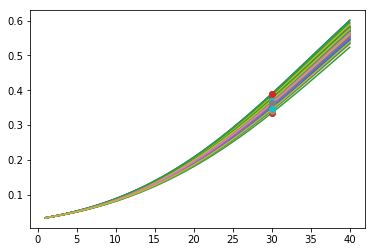

40


In [72]:
## use the above dose array to calc NTCP - will extract the correct dose point

ntcp_hn_imrt = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=all_d_array,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps']#[0][29] ## get NTCP after 30#

fracs = [i for i in range(1,len(ntcp_hn_imrt[0])+1)]

for i in ntcp_hn_imrt:
    
    plt.plot(fracs,i)
    plt.plot(30,i[29],'o')
plt.show()
#ntcp_hn_imrt
print(len(ntcp_hn_imrt[0]))

## Variation in calculated TCP with systematic dose shift
- Calcualte the change in NTCP for a systematic dose shift.
- -5% to +5% shifts, every 0.25%

In [199]:
par_imrt

[17.084597070000001,
 20.949804310000001,
 23.38983374,
 18.686619239999999,
 22.192625899999999,
 21.038006459999998,
 23.167685710000001,
 22.104871410000001,
 27.422374430000001,
 21.722923080000001,
 23.65160294,
 23.88736407,
 24.452034000000001,
 20.664840600000002,
 21.918105800000003,
 23.03782859,
 25.122245759999998,
 23.95218062,
 26.72754119,
 24.672429910000002,
 22.447651669999999,
 22.527160779999999,
 23.952836940000001,
 25.036230499999999,
 26.757099800000002,
 23.97241953,
 25.743383040000001,
 26.831711540000001,
 27.691088659999998,
 25.586321330000001,
 24.10059184,
 25.528449370000001,
 27.322314729999999,
 25.49491192,
 30.728569279999999,
 30.66945175,
 28.008188300000004,
 35.465779509999997,
 32.229197370000001,
 31.83002729,
 31.729554459999999,
 37.033325480000002,
 37.548870860000001,
 33.80548692,
 37.614415350000002,
 39.375612879999998,
 41.143216559999999,
 39.696314979999997,
 44.666843239999999,
 40.160808080000002,
 44.00734216,
 43.827715519999998,

In [6]:
## nominal doses - each value is a patient that needs to be modelled
## need to feed single fraction dose into model

## generate teh nominal dose/fraction for each case
## these will be used throughout

rect_nom = [i/37 for i in rect] ## mean=1.1Gy/#, sd=0.04Gy
hn_imrt_nom = [i/30 for i in par_imrt] ## mean=1.17Gy/#, sd=0.43Gy/#
hn_conf_nom = [i/30 for i in par_conf] ## mean=2.02Gy/# sd=0.22Gy/# ()

## hn = [29] = 30# in each case
## prost = [36] = 37#

In [8]:
## generate nominal doses for each patient.
## feed these into model with dose shift applied
## store required NCP values

all_d_hn_imrt = []
all_d_hn_conf = []
all_d_rect = []

## loop each patient
for the_d in hn_imrt_nom:
    ## generate fraction doses for each patient
    fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=0,d_trend=0)
    ## store list of each pateitns fraction doses in another list
    all_d_hn_imrt.append(list(fracs[0]))
    
for the_d in hn_conf_nom:
    ## generate fraction doses for each patient
    fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=0,d_trend=0)
    ## store list of each pateitns fraction doses in another list
    all_d_hn_conf.append(list(fracs[0]))
    
for the_d in rect_nom:
    ## generate fraction doses for each patient
    fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=0,d_trend=0)
    ## store list of each pateitns fraction doses in another list
    all_d_rect.append(list(fracs[0]))
    
## convert complete list to array to pass to NTCP  
## this is an array of the dose/fraction to be fed to the NTCP model
all_d_hn_imrt_array = np.asarray(all_d_hn_imrt)
all_d_hn_conf_array = np.asarray(all_d_hn_conf)
all_d_rect_array = np.asarray(all_d_rect)

## calculate NTCP results from this dose array
## this returns only the NTCP at the specified fraction

## shifts in dose to assess ***********************************
shifts = np.linspace(-5,5,41)
#shifts = [-5,-3,0,3,5]

## loop each dose shift and store results in dict
hn_imrt_all = {}
hn_conf_all = {}
rect_all = {}

for shift in shifts:
    print(shift)
    shift_factor = 1+(shift/100) ## convert percentage shift to multiplication factor
    
    
    ## imrt case
    ntcp_hn_imrt = model.complete_NTCP_calc(#d_data=[64,74],
                                           #ntcp_data=[0.36,0.47],
                                           irrad_perc = 100,
                                           frac_doses=all_d_hn_imrt_array*shift_factor, ## can multiple array by shift
                                           max_dose=100,
                                            # HN values - imrt/conf have dif frac_doses
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)['patient_ntcps'][:,29] ## get NTCP after 30#
    
    ntcp_hn_imrt_mean = np.mean(ntcp_hn_imrt,axis=0)
    ## store the mean population NTCP with associated shift value in dict
    hn_imrt_all[shift] = ntcp_hn_imrt_mean
    
    
    ## conformal case    
    ntcp_hn_conf = model.complete_NTCP_calc(#d_data=[64,74],
                                           #ntcp_data=[0.36,0.47],
                                           irrad_perc = 100,
                                           frac_doses=all_d_hn_conf_array*shift_factor, ## can multiple array by shift
                                           max_dose=100,
                                            # HN values - imrt/conf have dif frac_doses
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)['patient_ntcps'][:,29] ## get NTCP after 30#

    ntcp_hn_conf_mean = np.mean(ntcp_hn_conf,axis=0)
    ## store the mean population NTCP with associated shift value in dict
    hn_conf_all[shift] = ntcp_hn_conf_mean
    
    
    ## rectum case
    ntcp_rect = model.complete_NTCP_calc(#d_data=[64,74],
                                           #ntcp_data=[0.36,0.47],
                                           irrad_perc = 100,
                                           frac_doses=all_d_rect_array*shift_factor, ## can multiple array by shift
                                           max_dose=100,
                                            # rectum values
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)['patient_ntcps'][:,36] ## get NTCP after 37#
    
    ntcp_rect_mean = np.mean(ntcp_rect,axis=0)
    ## store the mean population NTCP with associated shift value in dict
    rect_all[shift] = ntcp_rect_mean


## convert NTCP to percentage change
hn_imrt_perc = [((hn_imrt_all[i]/hn_imrt_all[0])-1)*100 for i in sorted(hn_imrt_all)]
hn_conf_perc = [((hn_conf_all[i]/hn_conf_all[0])-1)*100 for i in sorted(hn_conf_all)]
rect_perc = [((rect_all[i]/rect_all[0])-1)*100 for i in sorted(rect_all)]

-5.0
-4.75
-4.5
-4.25
-4.0
-3.75
-3.5
-3.25
-3.0
-2.75
-2.5
-2.25
-2.0
-1.75
-1.5
-1.25
-1.0
-0.75
-0.5
-0.25
0.0
0.25
0.5
0.75
1.0
1.25
1.5
1.75
2.0
2.25
2.5
2.75
3.0
3.25
3.5
3.75
4.0
4.25
4.5
4.75
5.0


In [9]:
rect_all

{-5.0: 0.4816372057068149,
 -4.75: 0.48834392702497742,
 -4.5: 0.49505181196642056,
 -4.25: 0.50175895961557371,
 -4.0: 0.50846347153510263,
 -3.75: 0.51516345337765768,
 -3.5: 0.52185701648913896,
 -3.25: 0.5285422795012471,
 -3.0: 0.53521736991107649,
 -2.75: 0.54188042564556749,
 -2.5: 0.54852959660865519,
 -2.25: 0.55516304620899648,
 -2.0: 0.56177895286619195,
 -1.75: 0.56837551149348842,
 -1.5: 0.57495093495496408,
 -1.25: 0.58150345549529181,
 -1.0: 0.58803132614019671,
 -0.75: 0.59453282206581937,
 -0.5: 0.60100624193523255,
 -0.25: 0.60744990920044595,
 0.0: 0.61386217336829285,
 0.25: 0.62024141122867149,
 0.5: 0.62658602804368568,
 0.75: 0.63289445869630723,
 1.0: 0.63916516879726093,
 1.25: 0.64539665574892668,
 1.5: 0.65158744976511029,
 1.75: 0.65773611484564742,
 2.0: 0.66384124970487068,
 2.25: 0.6699014886530712,
 2.5: 0.67591550243015819,
 2.75: 0.68188199899082358,
 3.0: 0.68779972424059566,
 3.25: 0.69366746272226509,
 3.5: 0.6994840382522437,
 3.75: 0.7052483145065

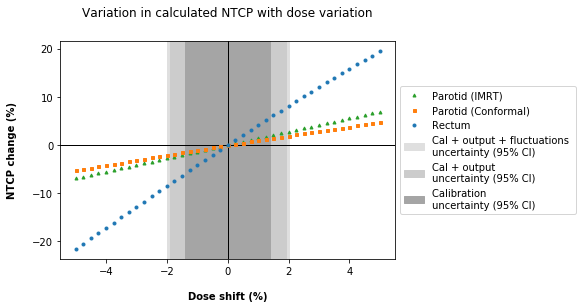

In [10]:
## plot the above results 

plt.plot(shifts,hn_imrt_perc,marker_hn_imrt,ms=3,color=color_hn_imrt,label='Parotid (IMRT)')
plt.plot(shifts,hn_conf_perc,marker_hn_conf,ms=3,color=color_hn_conf,label='Parotid (Conformal)')
plt.plot(shifts,rect_perc,marker_p,ms=3,color=color_p,label='Rectum')

plt.axhline(0,color='black',lw=1,zorder=0)
plt.axvline(0,color='black',lw=1,zorder=0)

plt.xlabel('Dose shift (%)')
plt.ylabel('NTCP change (%)')
plt.title('Variation in calculated NTCP with dose variation')


## shade the regions of interest with different colours and labels
output_errors = {1.4:{'label':'Calibration \nuncertainty (95% CI)',
                    'color':'#a5a5a5'},
                 1.9:{'label':'Cal + output \nuncertainty (95% CI)',
                   'color':'#cccccc'},
                2:{'label':'Cal + output + fluctuations \nuncertainty (95% CI)',
                   'color':'#dfdfdf'}}

for val in sorted(output_errors,reverse=True):
    plt.axvspan(-val,val,alpha=1,color=output_errors[val]['color'],zorder=0,label=output_errors[val]['label'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('NTCP-systematic_dose_dif-corr.png',dpi=300,bbox_inches='tight')

plt.show()

In [32]:
## get values for table -3 to +3% with 0.5% increments
## order rectum / conf / imrt

for i in range(len(shifts)):
    if i % 0.5 == 0:
        print(shifts[i],rect_perc[i],hn_conf_perc[i],hn_imrt_perc[i])

-5.0 -21.539846141 -5.24896691252 -6.92211314901
-4.75 -20.4473010048 -4.9751734369 -6.57594740888
-4.5 -19.3545663109 -4.70254024657 -6.22975163464
-4.25 -18.261951724 -4.43107356297 -5.88353198715
-4.0 -17.1697665055 -4.16077947473 -5.5372946048
-3.75 -16.0783192502 -3.89166393761 -5.19104560318
-3.5 -14.9879176256 -3.62373277442 -4.84479110367
-3.25 -13.8988681122 -3.35699167494 -4.49853708733
-3.0 -12.8114757464 -3.09144619587 -4.15228968605
-2.75 -11.7260438655 -2.82710176088 -3.80605489051
-2.5 -10.6428738557 -2.56396366053 -3.45983869557
-2.25 -9.56226490341 -2.30203705242 -3.11364707072
-2.0 -8.48451374945 -2.04132696114 -2.76748595969
-1.75 -7.40991444793 -1.78183827842 -2.42136128002
-1.5 -6.33875812869 -1.52357576322 -2.07527892269
-1.25 -5.2713327644 -1.26654404186 -1.72924475174
-1.0 -4.20792294244 -1.01074760816 -1.38326460386
-0.75 -3.14880964181 -0.75619082365 -1.03734428807
-0.5 -2.09427001545 -0.502877917721 -0.691489585302
-0.25 -1.04457717808 -0.250812987885 -0.3457

In [181]:
all_d_hn_imrt_array*1.1

array([[ 0.626,  0.626,  0.626, ...,  0.626,  0.626,  0.626],
       [ 0.768,  0.768,  0.768, ...,  0.768,  0.768,  0.768],
       [ 0.858,  0.858,  0.858, ...,  0.858,  0.858,  0.858],
       ..., 
       [ 2.149,  2.149,  2.149, ...,  2.149,  2.149,  2.149],
       [ 2.059,  2.059,  2.059, ...,  2.059,  2.059,  2.059],
       [ 2.192,  2.192,  2.192, ...,  2.192,  2.192,  2.192]])

In [91]:
shifts = np.linspace(-5,5,41)
shifts

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75,  5.  ])

## Change in variation due to beam calibration uncertainty improvement
- Model dose shifts taken from a normal distribution with 0.8% and 04% SD.
- Calculate the SD in NTCP for each case.
- Have to run model 100 times for eahc case - 100 normally distrbuted balues of dose_multiplier fraction.
    - Essentially follows the same process as above, but with more dose shift values which are nomrally distributed.

In [72]:
## generate nomrally distributed percentage difs in dose cal
np.random.seed(0) ## for consistency

## loop both 0.4 and 0.8% SD
for cal_sd in [0.4,0.8]:

    shifts = np.random.normal(loc=0,scale=cal_sd,size=100)

    ## loop each dose shift and store results in list - dont need any other info other than the result
    hn_imrt_all = []
    hn_conf_all = []
    rect_all = []

    for i in range(len(shifts)):
        print(i+1,'of',len(shifts))
        shift_factor = 1+(shifts[i]/100) ## convert percentage shift to multiplication factor
        #print(shift_factor)


        ## imrt case
        ntcp_hn_imrt = model.complete_NTCP_calc(#d_data=[64,74],
                                               #ntcp_data=[0.36,0.47],
                                               irrad_perc = 100,
                                               frac_doses=all_d_hn_imrt_array*shift_factor, ## can multiple array by shift
                                               max_dose=100,
                                                # HN values - imrt/conf have dif frac_doses
                                               ntcp_params={'td50_1':(31.4,0),
                                                            'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                            'm':(0.53,0),
                                                            'n':(1,0)}, #(1,0)
                                               fit_vals=False)['patient_ntcps'][:,29] ## get NTCP after 30#

        ntcp_hn_imrt_mean = np.mean(ntcp_hn_imrt,axis=0)
        ## store the mean population NTCP
        hn_imrt_all.append(ntcp_hn_imrt_mean)


        ## conformal case    
        ntcp_hn_conf = model.complete_NTCP_calc(#d_data=[64,74],
                                               #ntcp_data=[0.36,0.47],
                                               irrad_perc = 100,
                                               frac_doses=all_d_hn_conf_array*shift_factor, ## can multiple array by shift
                                               max_dose=100,
                                                # HN values - imrt/conf have dif frac_doses
                                               ntcp_params={'td50_1':(31.4,0),
                                                            'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                            'm':(0.53,0),
                                                            'n':(1,0)}, #(1,0)
                                               fit_vals=False)['patient_ntcps'][:,29] ## get NTCP after 30#

        ntcp_hn_conf_mean = np.mean(ntcp_hn_conf,axis=0)
        ## store the mean population NTCP
        hn_conf_all.append(ntcp_hn_conf_mean)


        ## rectum case
        ntcp_rect = model.complete_NTCP_calc(#d_data=[64,74],
                                               #ntcp_data=[0.36,0.47],
                                               irrad_perc = 100,
                                               frac_doses=all_d_rect_array*shift_factor, ## can multiple array by shift
                                               max_dose=100,
                                                # rectum values
                                               ntcp_params={'td50_1':(68.5,0),
                                                            'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                            'm':(0.15,0),
                                                            'n':(0.13,0)}, #(1,0)
                                               fit_vals=False)['patient_ntcps'][:,36] ## get NTCP after 37#

        ntcp_rect_mean = np.mean(ntcp_rect,axis=0)
        ## store the mean population NTCP
        rect_all.append(ntcp_rect_mean)

    print('---')
    print('Results for calibration SD:', cal_sd)
    print('hn imrt sd perc:', 100*np.std(hn_imrt_all)/np.mean(hn_imrt_all))
    print('hn conf sd perc:', 100*np.std(hn_conf_all)/np.mean(hn_conf_all))
    print('rect sd perc:', 100*np.std(rect_all)/np.mean(rect_all))
    print('---')

1 of 100
2 of 100
3 of 100
4 of 100
5 of 100
6 of 100
7 of 100
8 of 100
9 of 100
10 of 100
11 of 100
12 of 100
13 of 100
14 of 100
15 of 100
16 of 100
17 of 100
18 of 100
19 of 100
20 of 100
21 of 100
22 of 100
23 of 100
24 of 100
25 of 100
26 of 100
27 of 100
28 of 100
29 of 100
30 of 100
31 of 100
32 of 100
33 of 100
34 of 100
35 of 100
36 of 100
37 of 100
38 of 100
39 of 100
40 of 100
41 of 100
42 of 100
43 of 100
44 of 100
45 of 100
46 of 100
47 of 100
48 of 100
49 of 100
50 of 100
51 of 100
52 of 100
53 of 100
54 of 100
55 of 100
56 of 100
57 of 100
58 of 100
59 of 100
60 of 100
61 of 100
62 of 100
63 of 100
64 of 100
65 of 100
66 of 100
67 of 100
68 of 100
69 of 100
70 of 100
71 of 100
72 of 100
73 of 100
74 of 100
75 of 100
76 of 100
77 of 100
78 of 100
79 of 100
80 of 100
81 of 100
82 of 100
83 of 100
84 of 100
85 of 100
86 of 100
87 of 100
88 of 100
89 of 100
90 of 100
91 of 100
92 of 100
93 of 100
94 of 100
95 of 100
96 of 100
97 of 100
98 of 100
99 of 100
100 of 100
---
Resu

In [ ]:
## As above but just for 1% SD to show impact of machien scheduling.
## want to save the entire curve this time to produce plot.

In [156]:
np.random.seed(0) ## for consistency

## generate normally distributed shifts with 1% SD
shifts = np.random.normal(loc=0,scale=1,size=100)

## loop each dose shift and store results in list - dont need any other info other than the result
hn_imrt_all = []
hn_conf_all = []
rect_all = []

for i in range(len(shifts)):
    print(i+1,'of',len(shifts))
    shift_factor = 1+(shifts[i]/100) ## convert percentage shift to multiplication factor

    ## imrt case
    ntcp_hn_imrt = model.complete_NTCP_calc(#d_data=[64,74],
                                           #ntcp_data=[0.36,0.47],
                                           irrad_perc = 100,
                                           frac_doses=all_d_hn_imrt_array*shift_factor, ## can multiple array by shift
                                           max_dose=100,
                                            # HN values - imrt/conf have dif frac_doses
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)['patient_ntcps']# store all patient NTCPs to allow calc of mean NTCP

    ntcp_hn_imrt_mean = np.mean(ntcp_hn_imrt,axis=0)
    ## store the mean population NTCP
    hn_imrt_all.append(ntcp_hn_imrt_mean)


    ## conformal case    
    ntcp_hn_conf = model.complete_NTCP_calc(#d_data=[64,74],
                                           #ntcp_data=[0.36,0.47],
                                           irrad_perc = 100,
                                           frac_doses=all_d_hn_conf_array*shift_factor, ## can multiple array by shift
                                           max_dose=100,
                                            # HN values - imrt/conf have dif frac_doses
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)['patient_ntcps']# store all patient NTCPs to allow calc of mean NTCP

    ntcp_hn_conf_mean = np.mean(ntcp_hn_conf,axis=0)
    ## store the mean population NTCP
    hn_conf_all.append(ntcp_hn_conf_mean)


    ## rectum case
    ntcp_rect = model.complete_NTCP_calc(#d_data=[64,74],
                                           #ntcp_data=[0.36,0.47],
                                           irrad_perc = 100,
                                           frac_doses=all_d_rect_array*shift_factor, ## can multiple array by shift
                                           max_dose=100,
                                            # rectum values
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)['patient_ntcps']# store all patient NTCPs to allow calc of mean NTCP

    ntcp_rect_mean = np.mean(ntcp_rect,axis=0)
    ## store the mean population NTCP
    rect_all.append(ntcp_rect_mean)


1 of 100
2 of 100
3 of 100
4 of 100
5 of 100
6 of 100
7 of 100
8 of 100
9 of 100
10 of 100
11 of 100
12 of 100
13 of 100
14 of 100
15 of 100
16 of 100
17 of 100
18 of 100
19 of 100
20 of 100
21 of 100
22 of 100
23 of 100
24 of 100
25 of 100
26 of 100
27 of 100
28 of 100
29 of 100
30 of 100
31 of 100
32 of 100
33 of 100
34 of 100
35 of 100
36 of 100
37 of 100
38 of 100
39 of 100
40 of 100
41 of 100
42 of 100
43 of 100
44 of 100
45 of 100
46 of 100
47 of 100
48 of 100
49 of 100
50 of 100
51 of 100
52 of 100
53 of 100
54 of 100
55 of 100
56 of 100
57 of 100
58 of 100
59 of 100
60 of 100
61 of 100
62 of 100
63 of 100
64 of 100
65 of 100
66 of 100
67 of 100
68 of 100
69 of 100
70 of 100
71 of 100
72 of 100
73 of 100
74 of 100
75 of 100
76 of 100
77 of 100
78 of 100
79 of 100
80 of 100
81 of 100
82 of 100
83 of 100
84 of 100
85 of 100
86 of 100
87 of 100
88 of 100
89 of 100
90 of 100
91 of 100
92 of 100
93 of 100
94 of 100
95 of 100
96 of 100
97 of 100
98 of 100
99 of 100
100 of 100


In [157]:
len(rect_all[1])
len(num_frac[:40])

40

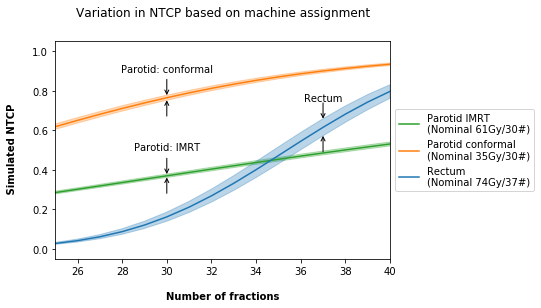

hn imrt mean 0.369860851325
hn imrt 5th 0.361301588627
hn imrt 95th 0.378694870096
hn imrt 5th-95th 1.7 %
hn conf mean 0.764809443328
hn conf 5th 0.751878838647
hn conf 95th 0.777875619554
hn conf 5th-95th 2.6 %
rect mean 0.615120558275
rect 5th 0.571936527091
rect 95th 0.658714681441
rect 5th-95th 8.7 %


In [208]:
## now have to plot against number of fractions
## will need to specify nominal total dose

## use this arrya for plotting from 0 to n where n is the number of fractions for each case
## will now plot NTCP vs number of fractions as modellign has changed slightly
## coud generate models for more fractions - up to 100Gy?
## imrt and conf would still have slightly dif curves as dif paitent pops
num_frac = [i+1 for i in range(100)]

## genetate mean, 5th, 95th percentiles

hn_imrt_mean = np.mean(hn_imrt_all,axis=0)
hn_imrt_5 = np.percentile(hn_imrt_all,5,axis=0)
hn_imrt_95 = np.percentile(hn_imrt_all,95,axis=0)

hn_conf_mean = np.mean(hn_conf_all,axis=0)
hn_conf_5 = np.percentile(hn_conf_all,5,axis=0)
hn_conf_95 = np.percentile(hn_conf_all,95,axis=0)

rect_mean = np.mean(rect_all,axis=0)
rect_5 = np.percentile(rect_all,5,axis=0)
rect_95 = np.percentile(rect_all,95,axis=0)

## HN imrt
plt.plot(num_frac[:len(hn_imrt_mean)],hn_imrt_mean,color=color_hn_imrt,
        label='Parotid IMRT \n(Nominal 61Gy/30#)')
plt.fill_between(num_frac[:len(hn_imrt_mean)],hn_imrt_5,hn_imrt_95,
                 color=color_hn_imrt,alpha=0.3,zorder=0)
## HN conf
plt.plot(num_frac[:len(hn_conf_mean)],hn_conf_mean,color=color_hn_conf,
        label='Parotid conformal \n(Nominal 35Gy/30#)')
plt.fill_between(num_frac[:len(rect_mean)],hn_conf_5,hn_conf_95,
                 color=color_hn_conf,alpha=0.3,zorder=0)
## Rectum
plt.plot(num_frac[:len(rect_mean)],rect_mean,color=color_p,
        label='Rectum \n(Nominal 74Gy/37#)')
plt.fill_between(num_frac[:len(rect_mean)],rect_5,rect_95,
                 color=color_p,alpha=0.3,zorder=0)

plt.xlim(25,40)
plt.ylim(-0.05,1.05)

plt.xlabel('Number of fractions')
plt.ylabel(' Simulated NTCP')
plt.title('Variation in NTCP based on machine assignment')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## add arrows to indicate fraction of interest

## HN IMRT
plt.annotate(s='', xy=(30,hn_imrt_5[29]-0.08), xytext=(30,hn_imrt_5[29]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))
plt.annotate(s='', xy=(30,hn_imrt_95[29]+0.08), xytext=(30,hn_imrt_95[29]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))

## HN IMRT
plt.annotate(s='', xy=(30,hn_conf_5[29]-0.08), xytext=(30,hn_conf_5[29]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))
plt.annotate(s='', xy=(30,hn_conf_95[29]+0.08), xytext=(30,hn_conf_95[29]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))

## Rectum
plt.annotate(s='', xy=(37,rect_5[36]-0.08), xytext=(37,rect_5[36]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))
plt.annotate(s='', xy=(37,rect_95[36]+0.08), xytext=(37,rect_95[36]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))

## add text
plt.text(30,hn_conf_mean[29]+0.13,'Parotid: conformal',horizontalalignment='center')
plt.text(30,hn_imrt_mean[29]+0.13,'Parotid: IMRT',horizontalalignment='center')
plt.text(37,rect_mean[36]+0.13,'Rectum',horizontalalignment='center')

#plt.savefig('variation due to machine scheduling.png',dpi=300,bbox_inches='tight')

plt.show()

## print mean, 5th and 95th percentiles for each case

print('hn imrt mean', hn_imrt_mean[29])
print('hn imrt 5th', hn_imrt_5[29])
print('hn imrt 95th', hn_imrt_95[29])
print('hn imrt 5th-95th', round(100*(hn_imrt_95[29]-hn_imrt_5[29]),1),'%')

print('hn conf mean', hn_conf_mean[29])
print('hn conf 5th', hn_conf_5[29])
print('hn conf 95th', hn_conf_95[29])
print('hn conf 5th-95th', round(100*(hn_conf_95[29]-hn_conf_5[29]),1),'%')

print('rect mean', rect_mean[36])
print('rect 5th', rect_5[36])
print('rect 95th', rect_95[36])
print('rect 5th-95th', round(100*(rect_95[36]-rect_5[36]),1),'%')

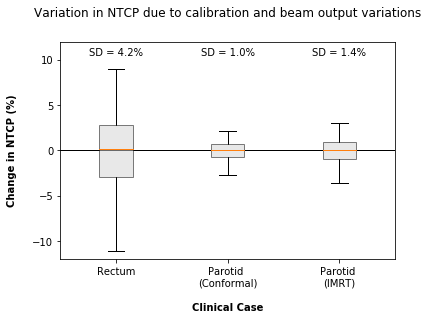

In [199]:
## plot boxplots of the NTCP for eah case at the poitns of interest.
hn_imrt_int = [hn_imrt_all[i][29] for i in range(len(hn_imrt_all))]
hn_conf_int = [hn_conf_all[i][29] for i in range(len(hn_conf_all))]
rect_int = [rect_all[i][36] for i in range(len(rect_all))]

## convert to relative % change

hn_imrt_int_perc = [((i/np.mean(hn_imrt_int))-1)*100 for i in hn_imrt_int]
hn_conf_int_perc = [((i/np.mean(hn_conf_int))-1)*100 for i in hn_conf_int]
rect_int_perc = [((i/np.mean(rect_int))-1)*100 for i in rect_int]

## get the data into 3 lists then combine for plotting
all_boxes = [rect_int_perc,hn_conf_int_perc,hn_imrt_int_perc]

## do the plot
plt.boxplot(all_boxes,patch_artist=True,boxprops=dict(facecolor="lightgrey",alpha=0.5))

plt.title('Variation in NTCP due to calibration and beam output variations')
plt.xlabel('Clinical Case')
plt.ylabel('Change in NTCP (%)')

plt.axhline(0,color='black',lw=1,zorder=0)

## display text for SDs
for i in range(len(all_boxes)):
    sd = np.std(all_boxes[i])
    text = 'SD = ' + str(round(sd,1)) + '%'
    #print(text)
    plt.text(i+1,10.5,text,horizontalalignment='center')


## tidy up
plt.ylim(-12,12)
#plt.xlim(0.4,3.6)

plt.yticks([-10,-5,0,5,10])
plt.xticks([1,2,3],['Rectum','Parotid \n(Conformal)', 'Parotid \n(IMRT)'])

#plt.savefig('NTCP box variation due to output.png',dpi=300,bbox_inches='tight')

plt.show()

## Variaton due to annual output drifts
- Vary from -10% to +10% , every 0.5%.

In [38]:
## generate nominal doses for each patient.
## feed these into model with dose drift applied
## store required NCP values

all_d_hn_imrt = []
all_d_hn_conf = []
all_d_rect = []

## need to save arrays of doses with the drift applied, tehn loop through these

hn_imrt_all = {}
hn_conf_all = {}
rect_all = {}

drift_annual = np.linspace(-10,10,41)
#drift_annual= [-10,0,10]

for drift in drift_annual:
    print(drift)
    drift_daily = drift/365

    ## loop each patient
    for the_d in hn_imrt_nom:
        ## generate fraction doses for each patient
        fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=0,d_trend=drift_daily)
        ## store list of each pateitns fraction doses in another list
        all_d_hn_imrt.append(list(fracs[0]))

    for the_d in hn_conf_nom:
        ## generate fraction doses for each patient
        fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=0,d_trend=drift_daily)
        ## store list of each pateitns fraction doses in another list
        all_d_hn_conf.append(list(fracs[0]))

    for the_d in rect_nom:
        ## generate fraction doses for each patient
        fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=0,d_trend=drift_daily)
        ## store list of each pateitns fraction doses in another list
        all_d_rect.append(list(fracs[0]))

    ## convert complete list to array to pass to NTCP  
    ## this is an array of the dose/fraction to be fed to the NTCP model
    all_d_hn_imrt_array = np.asarray(all_d_hn_imrt)
    all_d_hn_conf_array = np.asarray(all_d_hn_conf)
    all_d_rect_array = np.asarray(all_d_rect)

    ## calculate NTCP results from this dose array
    ## this returns only the NTCP at the specified fraction

    ## imrt case
    ntcp_hn_imrt = model.complete_NTCP_calc(#d_data=[64,74],
                                           #ntcp_data=[0.36,0.47],
                                           irrad_perc = 100,
                                           frac_doses=all_d_hn_imrt_array, ## can multiple array by shift
                                           max_dose=100,
                                            # HN values - imrt/conf have dif frac_doses
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)['patient_ntcps'][:,29] ## get NTCP after 30#

    ntcp_hn_imrt_mean = np.mean(ntcp_hn_imrt,axis=0)
    ## store the mean population NTCP with associated shift value in dict
    hn_imrt_all[drift] = ntcp_hn_imrt_mean


    ## conformal case    
    ntcp_hn_conf = model.complete_NTCP_calc(#d_data=[64,74],
                                           #ntcp_data=[0.36,0.47],
                                           irrad_perc = 100,
                                           frac_doses=all_d_hn_conf_array, ## can multiple array by shift
                                           max_dose=100,
                                            # HN values - imrt/conf have dif frac_doses
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)['patient_ntcps'][:,29] ## get NTCP after 30#

    ntcp_hn_conf_mean = np.mean(ntcp_hn_conf,axis=0)
    ## store the mean population NTCP with associated shift value in dict
    hn_conf_all[drift] = ntcp_hn_conf_mean


    ## rectum case
    ntcp_rect = model.complete_NTCP_calc(#d_data=[64,74],
                                           #ntcp_data=[0.36,0.47],
                                           irrad_perc = 100,
                                           frac_doses=all_d_rect_array, ## can multiple array by shift
                                           max_dose=100,
                                            # rectum values
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)['patient_ntcps'][:,36] ## get NTCP after 37#

    ntcp_rect_mean = np.mean(ntcp_rect,axis=0)
    ## store the mean population NTCP with associated shift value in dict
    rect_all[drift] = ntcp_rect_mean


## convert NTCP to percentage change
hn_imrt_perc = [((hn_imrt_all[i]/hn_imrt_all[0])-1)*100 for i in sorted(hn_imrt_all)]
hn_conf_perc = [((hn_conf_all[i]/hn_conf_all[0])-1)*100 for i in sorted(hn_conf_all)]
rect_perc = [((rect_all[i]/rect_all[0])-1)*100 for i in sorted(rect_all)]

-10.0
-9.5
-9.0
-8.5
-8.0
-7.5
-7.0
-6.5
-6.0
-5.5
-5.0
-4.5
-4.0
-3.5
-3.0
-2.5
-2.0
-1.5
-1.0
-0.5
0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0


In [39]:
rect_perc

[-1.0450759913147034,
 -0.99266654363285856,
 -0.94027308901987183,
 -0.88789569298598492,
 -0.83553442095943842,
 -0.78318933828600557,
 -0.7308605102288368,
 -0.67854800196806009,
 -0.62625187860044784,
 -0.57397220513920599,
 -0.5217090465135521,
 -0.46946246756846,
 -0.41723253306428232,
 -0.36501930767659507,
 -0.31282285599567583,
 -0.2606432425263705,
 -0.20848053168776026,
 -0.15633478781269528,
 -0.10420607514769475,
 -0.052094457852536191,
 0.0,
 0.052077234424507957,
 0.10413718152322282,
 0.15617977748625389,
 0.20820495859197319,
 0.26021266120730413,
 0.31220282178798797,
 0.36417537687887247,
 0.41613026311426715,
 0.46806741721820977,
 0.51998677600477716,
 0.57188827637824069,
 0.62377185533357693,
 0.67563744995671193,
 0.72748499742463224,
 0.77931443500589559,
 0.83112570006083075,
 0.88291873004178179,
 0.9346934624934633,
 0.98644983505327133,
 1.0381877854514165]

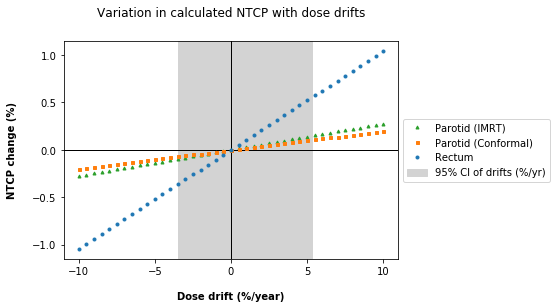

In [41]:
## plot the above results

plt.plot(drift_annual,hn_imrt_perc,marker_hn_imrt,ms=3,color=color_hn_imrt,label='Parotid (IMRT)')
plt.plot(drift_annual,hn_conf_perc,marker_hn_conf,ms=3,color=color_hn_conf,label='Parotid (Conformal)')
plt.plot(drift_annual,rect_perc,marker_p,ms=3,color=color_p,label='Rectum')

plt.axvline(0,color='black',lw=1,zorder=0)
plt.axhline(0,color='black',lw=1,zorder=0)
## shade the regions of interest with different colours and labels
plt.axvspan(-3.5,5.3,alpha=1,color='lightgrey',zorder=0,label='95% CI of drifts (%/yr)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Dose drift (%/year)')
plt.ylabel('NTCP change (%)')
plt.title('Variation in calculated NTCP with dose drifts')

plt.xticks([-10,-5,0,5,10])

#.savefig('NTCP-dose_drift_var-corr.png',dpi=300,bbox_inches='tight')

plt.show()

In [36]:
drift_annaul = np.linspace(-10,10,41)
drift_annaul

array([-10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,  -6.5,  -6. ,
        -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,  -2. ,  -1.5,
        -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,
         3.5,   4. ,   4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,
         8. ,   8.5,   9. ,   9.5,  10. ])

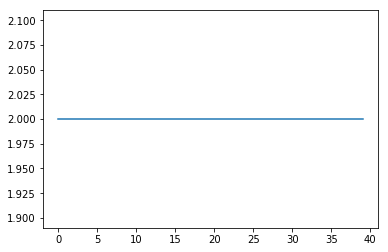

In [48]:
fracs = model.doses_array(n=1,n_frac=40,d=2,d_shift=0,d_sd=0,d_trend=0)
plt.plot(fracs[0])

## Simulate the daily dose variaiton.
- vary SD from 0 to 2% with 0.1% increments

Need to run 100 times for each SD to get the SD in pop NTCP, each run gives a single value.



In [200]:
## generate nominal doses for each patient.
## feed these into model with dose drift applied
## store required NTCP values

#all_d_hn_imrt = []
#all_d_hn_conf = []
#all_d_rect = []

## need to save arrays of doses with the drift applied, tehn loop through these

hn_imrt_all = {}
hn_conf_all = {}
rect_all = {}

sds = np.linspace(0,2,21)
#sds = [0,2]

repeats = 5

for sd in sds:
    print('sd:',sd,'%')
    
    ## repeat multiple times and store values in list, then stoe t
    hn_imrt_repeats = []
    hn_conf_repeats = []
    rect_repeats = []
    
    for repeat in range(repeats):
        print('repeat', repeat+1,'of',repeats)
        
        all_d_hn_imrt = []
        all_d_hn_conf = []
        all_d_rect = []

        ## loop each patient
        for the_d in hn_imrt_nom:
            ## generate fraction doses for each patient
            fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=sd,d_trend=0)
            ## store list of each pateitns fraction doses in another list
            all_d_hn_imrt.append(list(fracs[0]))

        for the_d in hn_conf_nom:
            ## generate fraction doses for each patient
            fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=sd,d_trend=0)
            ## store list of each pateitns fraction doses in another list
            all_d_hn_conf.append(list(fracs[0]))

        for the_d in rect_nom:
            ## generate fraction doses for each patient
            fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=sd,d_trend=0)
            ## store list of each pateitns fraction doses in another list
            all_d_rect.append(list(fracs[0]))

        ## convert complete list to array to pass to NTCP  
        ## this is an array of the dose/fraction to be fed to the NTCP model
        all_d_hn_imrt_array = np.asarray(all_d_hn_imrt)
        all_d_hn_conf_array = np.asarray(all_d_hn_conf)
        all_d_rect_array = np.asarray(all_d_rect)

        ## calculate NTCP results from this dose array
        ## this returns only the NTCP at the specified fraction

        ## imrt case
        ntcp_hn_imrt = model.complete_NTCP_calc(#d_data=[64,74],
                                               #ntcp_data=[0.36,0.47],
                                               irrad_perc = 100,
                                               frac_doses=all_d_hn_imrt_array, ## these are the daily doses
                                               max_dose=100,
                                                # HN values - imrt/conf have dif frac_doses
                                               ntcp_params={'td50_1':(31.4,0),
                                                            'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                            'm':(0.53,0),
                                                            'n':(1,0)}, #(1,0)
                                               fit_vals=False)['patient_ntcps'][:,29] ## get NTCP after 30#

        ntcp_hn_imrt_mean = np.mean(ntcp_hn_imrt,axis=0)
        hn_imrt_repeats.append(ntcp_hn_imrt_mean) ## store all mean values in list - store this list at the end in dict


        ## conformal case    
        ntcp_hn_conf = model.complete_NTCP_calc(#d_data=[64,74],
                                               #ntcp_data=[0.36,0.47],
                                               irrad_perc = 100,
                                               frac_doses=all_d_hn_conf_array, ## these are the daily doses
                                               max_dose=100,
                                                # HN values - imrt/conf have dif frac_doses
                                               ntcp_params={'td50_1':(31.4,0),
                                                            'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                            'm':(0.53,0),
                                                            'n':(1,0)}, #(1,0)
                                               fit_vals=False)['patient_ntcps'][:,29] ## get NTCP after 30#

        ntcp_hn_conf_mean = np.mean(ntcp_hn_conf,axis=0)
        hn_conf_repeats.append(ntcp_hn_conf_mean) ## store all mean values in list - store this list at the end in dict



        ## rectum case
        ntcp_rect = model.complete_NTCP_calc(#d_data=[64,74],
                                               #ntcp_data=[0.36,0.47],
                                               irrad_perc = 100,
                                               frac_doses=all_d_rect_array, ## these are the daily doses
                                               max_dose=100,
                                                # rectum values
                                               ntcp_params={'td50_1':(68.5,0),
                                                            'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                            'm':(0.15,0),
                                                            'n':(0.13,0)}, #(1,0)
                                               fit_vals=False)['patient_ntcps'][:,36] ## get NTCP after 37#

        ntcp_rect_mean = np.mean(ntcp_rect,axis=0)
        rect_repeats.append(ntcp_rect_mean) ## store all mean values in list - store this list at the end in dict
        
        
    ## store all the NTCP results (from the number of repeats) in a dict with the sd
    ## can tehn calculate SD etc from these
    hn_imrt_all[sd] = hn_imrt_repeats
    hn_conf_all[sd] = hn_conf_repeats
    rect_all[sd] = rect_repeats

## view the rectum SDs to check
#print(rect_all)

## calcualte the SD percentage for each dose SD%
#hn_imrt_perc = [100*(np.std(hn_imrt_all[i])/np.mean(hn_imrt_all[i])) for i in sorted(hn_imrt_all)]
#hn_conf_perc = [100*(np.std(hn_conf_all[i])/np.mean(hn_conf_all[i])) for i in sorted(hn_conf_all)]
#rect_perc = [100*(np.std(rect_all[i])/np.mean(rect_all[i])) for i in sorted(rect_all)]

print('simulation completed')

## save the data after completion - work with new variables just in case an error in code changes results
hn_imrt_all15a = hn_imrt_all
hn_conf_all15a = hn_conf_all
rect_all15a = rect_all
## combein all to save as single file
all_15a = [hn_imrt_all15a,hn_conf_all15a,rect_all15a]
save_pkl(all_15a,'all15a.pkl')

print('data saved')

sd: 0.0 %
repeat 1 of 5
repeat 2 of 5
repeat 3 of 5
repeat 4 of 5
repeat 5 of 5
sd: 0.1 %
repeat 1 of 5
repeat 2 of 5
repeat 3 of 5
repeat 4 of 5
repeat 5 of 5
sd: 0.2 %
repeat 1 of 5
repeat 2 of 5
repeat 3 of 5
repeat 4 of 5
repeat 5 of 5
sd: 0.3 %
repeat 1 of 5


KeyboardInterrupt: 

In [260]:
## generate nominal doses for each patient.
## feed these into model with dose drift applied
## store required NTCP values

#all_d_hn_imrt = []
#all_d_hn_conf = []
#all_d_rect = []

## need to save arrays of doses with the drift applied, tehn loop through these

hn_imrt_all = {}
hn_conf_all = {}
rect_all = {}

#sds = np.linspace(0,2,21)
sds = [0,0.5,1,2]

repeats = 100

for sd in sds:
    print('sd:',sd,'%')
    
    ## repeat multiple times and store values in list, then stoe t
    hn_imrt_repeats = []
    hn_conf_repeats = []
    rect_repeats = []
    
    for repeat in range(repeats):
        print('repeat', repeat+1,'of',repeats)
        
        all_d_hn_imrt = []
        all_d_hn_conf = []
        all_d_rect = []

        ## loop each patient
        for the_d in hn_imrt_nom:
            ## generate fraction doses for each patient
            fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=sd,d_trend=0)
            ## store list of each pateitns fraction doses in another list
            all_d_hn_imrt.append(list(fracs[0]))

        for the_d in hn_conf_nom:
            ## generate fraction doses for each patient
            fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=sd,d_trend=0)
            ## store list of each pateitns fraction doses in another list
            all_d_hn_conf.append(list(fracs[0]))

        for the_d in rect_nom:
            ## generate fraction doses for each patient
            fracs = model.doses_array(n=1,n_frac=40,d=the_d,d_shift=0,d_sd=sd,d_trend=0)
            ## store list of each pateitns fraction doses in another list
            all_d_rect.append(list(fracs[0]))

        ## convert complete list to array to pass to NTCP  
        ## this is an array of the dose/fraction to be fed to the NTCP model
        
        ## convert to just a single dose value in each array
        
        all_d_hn_imrt_array1 = np.asarray(all_d_hn_imrt)
        all_d_hn_conf_array1 = np.asarray(all_d_hn_conf)
        all_d_rect_array1 = np.asarray(all_d_rect)
        
        ## this part converts teh above to a single cumulative dose...
        all_d_hn_imrt_array = np.asarray([[np.cumsum(all_d_hn_imrt_array1,axis=1)[i][29]] 
                                          for i in range(len(np.cumsum(all_d_hn_imrt_array1,axis=1)))])
        all_d_hn_conf_array = np.asarray([[np.cumsum(all_d_hn_conf_array1,axis=1)[i][29]] 
                                          for i in range(len(np.cumsum(all_d_hn_conf_array1,axis=1)))])
        all_d_rect_array = np.asarray([[np.cumsum(all_d_rect_array1,axis=1)[i][36]] 
                                          for i in range(len(np.cumsum(all_d_rect_array1,axis=1)))])

        ## calculate NTCP results from this dose array
        ## this returns only the NTCP at the specified fraction

        ## imrt case
        ntcp_hn_imrt = model.complete_NTCP_calc(#d_data=[64,74],
                                               #ntcp_data=[0.36,0.47],
                                               irrad_perc = 100,
                                               frac_doses=all_d_hn_imrt_array, ## these are the daily doses
                                               max_dose=100,
                                                # HN values - imrt/conf have dif frac_doses
                                               ntcp_params={'td50_1':(31.4,0),
                                                            'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                            'm':(0.53,0),
                                                            'n':(1,0)}, #(1,0)
                                               fit_vals=False)['patient_ntcps'][:]#[:,29] ## get NTCP after 30#

        ntcp_hn_imrt_mean = np.mean(ntcp_hn_imrt,axis=0)
        hn_imrt_repeats.append(ntcp_hn_imrt_mean) ## store all mean values in list - store this list at the end in dict


        ## conformal case    
        ntcp_hn_conf = model.complete_NTCP_calc(#d_data=[64,74],
                                               #ntcp_data=[0.36,0.47],
                                               irrad_perc = 100,
                                               frac_doses=all_d_hn_conf_array, ## these are the daily doses
                                               max_dose=100,
                                                # HN values - imrt/conf have dif frac_doses
                                               ntcp_params={'td50_1':(31.4,0),
                                                            'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                            'm':(0.53,0),
                                                            'n':(1,0)}, #(1,0)
                                               fit_vals=False)['patient_ntcps'][:]#[:,29] ## get NTCP after 30#

        ntcp_hn_conf_mean = np.mean(ntcp_hn_conf,axis=0)
        hn_conf_repeats.append(ntcp_hn_conf_mean) ## store all mean values in list - store this list at the end in dict



        ## rectum case
        ntcp_rect = model.complete_NTCP_calc(#d_data=[64,74],
                                               #ntcp_data=[0.36,0.47],
                                               irrad_perc = 100,
                                               frac_doses=all_d_rect_array, ## these are the daily doses
                                               max_dose=100,
                                                # rectum values
                                               ntcp_params={'td50_1':(68.5,0),
                                                            'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                            'm':(0.15,0),
                                                            'n':(0.13,0)}, #(1,0)
                                               fit_vals=False)['patient_ntcps'][:]#[:,36] ## get NTCP after 37#

        ntcp_rect_mean = np.mean(ntcp_rect,axis=0)
        rect_repeats.append(ntcp_rect_mean) ## store all mean values in list - store this list at the end in dict
        
        
    ## store all the NTCP results (from the number of repeats) in a dict with the sd
    ## can tehn calculate SD etc from these
    hn_imrt_all[sd] = hn_imrt_repeats
    hn_conf_all[sd] = hn_conf_repeats
    rect_all[sd] = rect_repeats

## view the rectum SDs to check
#print(rect_all)

## calcualte the SD percentage for each dose SD%
#hn_imrt_perc = [100*(np.std(hn_imrt_all[i])/np.mean(hn_imrt_all[i])) for i in sorted(hn_imrt_all)]
#hn_conf_perc = [100*(np.std(hn_conf_all[i])/np.mean(hn_conf_all[i])) for i in sorted(hn_conf_all)]
#rect_perc = [100*(np.std(rect_all[i])/np.mean(rect_all[i])) for i in sorted(rect_all)]

print('simulation completed')

## save the data after completion - work with new variables just in case an error in code changes results
hn_imrt_all_new = hn_imrt_all
hn_conf_all_new = hn_conf_all
rect_all_new = rect_all
## combein all to save as single file
all_new500 = [hn_imrt_all_new,hn_conf_all_new,rect_all_new]
#save_pkl(all_new500,'allnew500.pkl')
#print('new 500 data saved')

sd: 0 %
repeat 1 of 100
repeat 2 of 100
repeat 3 of 100
repeat 4 of 100
repeat 5 of 100
repeat 6 of 100
repeat 7 of 100
repeat 8 of 100
repeat 9 of 100
repeat 10 of 100
repeat 11 of 100
repeat 12 of 100
repeat 13 of 100
repeat 14 of 100
repeat 15 of 100
repeat 16 of 100
repeat 17 of 100
repeat 18 of 100
repeat 19 of 100
repeat 20 of 100
repeat 21 of 100
repeat 22 of 100
repeat 23 of 100
repeat 24 of 100
repeat 25 of 100
repeat 26 of 100
repeat 27 of 100
repeat 28 of 100
repeat 29 of 100
repeat 30 of 100
repeat 31 of 100
repeat 32 of 100
repeat 33 of 100
repeat 34 of 100
repeat 35 of 100
repeat 36 of 100
repeat 37 of 100
repeat 38 of 100
repeat 39 of 100
repeat 40 of 100
repeat 41 of 100
repeat 42 of 100
repeat 43 of 100
repeat 44 of 100
repeat 45 of 100
repeat 46 of 100
repeat 47 of 100
repeat 48 of 100
repeat 49 of 100
repeat 50 of 100
repeat 51 of 100
repeat 52 of 100
repeat 53 of 100
repeat 54 of 100
repeat 55 of 100
repeat 56 of 100
repeat 57 of 100
repeat 58 of 100
repeat 59 of 10

In [4]:
all_new500 = load_pkl('allnew500.pkl')

hn_imrt_combined = all_new500[0]
hn_conf_combined = all_new500[1]
rect_combined = all_new500[2]

len(rect_combined[0])

500

0.0 1.45235363916e-14
0.1 0.00230553246856
1.1 0.0260400008961
1.7 0.0395119955378
0.6 0.0138275710645
1.6 0.0360092904149
1.5 0.035207709199
1.3 0.0295482784261
2.0 0.0445598986456
0.9 0.0200033933641
1.2 0.0255830865032
1.4 0.0329804557249
1.8 0.0423448129573
1.0 0.0231577918777
0.3 0.00627735037037
1.9 0.045560075939
0.2 0.00474405259142
0.4 0.00969725829
0.8 0.0186975472956
0.7 0.0162972735251
0.5 0.0111915955526


KeyboardInterrupt: 

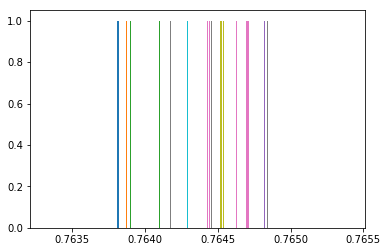

In [289]:
for i in hn_conf_combined:
    #plt.hist(hn_conf_combined[i],alpha=0.5,label=str(i),range=(0.763,0.7655),bins=10)
    print(i,100*np.std(hn_conf_combined[i])/np.mean(hn_conf_combined[i]))
    
#plt.legend()

plt.hist(hn_conf_combined[2],label='2')
plt.hist(hn_conf_combined[1],label='1')
plt.legend()

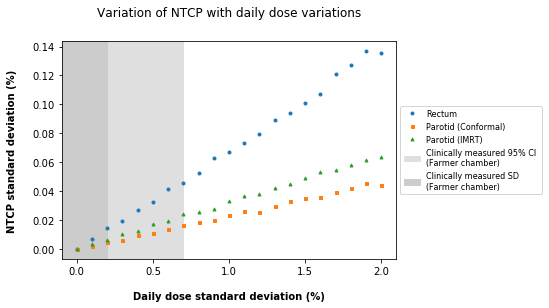

In [5]:
## calcualte the SD percentage for each dose SD%
hn_imrt_perc = [100*(np.std(hn_imrt_combined[i])/np.mean(hn_imrt_combined[i])) for i in sorted(hn_imrt_combined)]
hn_conf_perc = [100*(np.std(hn_conf_combined[i])/np.mean(hn_conf_combined[i])) for i in sorted(hn_conf_combined)]
rect_perc = [100*(np.std(rect_combined[i])/np.mean(rect_combined[i])) for i in sorted(rect_combined)]

## need to combine the previously saved all5.pkl resutls wityh additionally calcualted values.
## then calc teh SD from thr full set.

## create plot
sds1 =[i for i in sorted(hn_imrt_combined)]  ## get the SDS calculated

plt.plot(sds1,rect_perc,ls='',marker=marker_p,color=color_p,ms=3,label='Rectum')
plt.plot(sds1,hn_conf_perc,ls='',marker=marker_hn_conf,color=color_hn_conf,ms=3,label='Parotid (Conformal)')
plt.plot(sds1,hn_imrt_perc,ls='',marker=marker_hn_imrt,color=color_hn_imrt,ms=3,label='Parotid (IMRT)')


plt.axvspan(-1,0.7,alpha=1,color='#dfdfdf',zorder=0,label='Clinically measured 95% CI \n(Farmer chamber)')
plt.axvspan(-1,0.2,alpha=1,color='#cccccc',zorder=0,label='Clinically measured SD \n(Farmer chamber)')


plt.legend(fontsize=8,loc='center left', bbox_to_anchor=(1, 0.5))
#leg.get_frame().set_alpha(1)

plt.xlim(-0.1,2.1)
plt.xticks([0,0.5,1,1.5,2])
#plt.ylim(-0.1,1.6)
#plt.yticks([0,0.5,1,1.5])


plt.title('Variation of NTCP with daily dose variations')
plt.ylabel('NTCP standard deviation (%)')
plt.xlabel('Daily dose standard deviation (%)')

#plt.savefig('NTCP_daily_dose_SD-new.png',dpi=300,bbox_inches='tight')
plt.show()

In [10]:
for i in range(len(hn_imrt_perc)):
    print(sds1[i],round(rect_perc[i],3),round(hn_conf_perc[i],3),round(hn_imrt_perc[i],3))

0.0 0.0 0.0 0.0
0.1 0.007 0.002 0.003
0.2 0.014 0.005 0.007
0.3 0.019 0.006 0.01
0.4 0.027 0.01 0.012
0.5 0.033 0.011 0.017
0.6 0.042 0.014 0.019
0.7 0.045 0.016 0.024
0.8 0.053 0.019 0.025
0.9 0.063 0.02 0.028
1.0 0.067 0.023 0.033
1.1 0.073 0.026 0.037
1.2 0.079 0.026 0.038
1.3 0.089 0.03 0.042
1.4 0.094 0.033 0.045
1.5 0.101 0.035 0.049
1.6 0.107 0.036 0.053
1.7 0.121 0.04 0.055
1.8 0.127 0.042 0.058
1.9 0.137 0.046 0.062
2.0 0.136 0.045 0.064


In [203]:
## use this to combine saved and new values to increase number of datasets for better plot.

## all_5 is the saved values - can load from PKL file. #0 - imrt, 1=conf, 2=rect
all_5 = load_pkl('all5.pkl')
all_15load = load_pkl('all15a.pkl')

hn_imrt_prev = all_5[0] ## saved values
hn_imrt_new = all_15load[0]#hn_imrt_all ## new values to combine with saved
hn_conf_prev = all_5[1] ## saved values
hn_conf_new = all_15load[1]#hn_conf_all ## new values to combine with saved
rect_prev = all_5[2] ## saved values
rect_new = all_15load[2]#rect_all ## new values to combine with saved

## combine lists by adding them together - simplifiy repat with function

def combine_vals(prev,new):
    combined_dict = {}
    for i in sorted(new):
        prev_vals = prev[i]
        new_vals = new[i]
        combined_vals = prev_vals + new_vals
        combined_dict[i] = combined_vals
    return combined_dict

hn_imrt_combined = {}
hn_conf_combined = {}
rect_combined = {}

hn_imrt_combined = combine_vals(hn_imrt_prev,hn_imrt_new)
hn_conf_combined = combine_vals(hn_conf_prev,hn_conf_new)
rect_combined = combine_vals(rect_prev,rect_new)

#hn_imrt_combined

In [205]:
hn_imrt_combined

{0.0: [0.36955778185109028,
  0.36955778185109028,
  0.36955778185109023,
  0.36955778185109028,
  0.36955778185109034,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028,
  0.36955778185109028],
 0.20000000000000001: [0.36956611493538716,
  0.36956386656868123,
  0.36956853445905985,
  0.36956585710514506,
  0.36956662265350604,
  0.36955145437066111,
  0.36953255388455319,
  0.36958520852440196,
  0.36956769927050864,
  0.36960630930798449,
  0.36956143049436418,
  0.36958035674343731,
  0.36954138864823366,
  0.36952851694646677,
  0.36956583476723726,
  0.36956668042956936,
  0.36958098429800956,
  0.36951933066154669,
  0.36958402637084264,
  0.36956181591615933],
 0.40000000000000002: [0.36956625859612324,
  0.3695

In [71]:
## save the above results as a different vairable to combine with further repeats

hn_imrt_all5 = hn_imrt_all
hn_conf_all5 = hn_conf_all
rect_all5 = rect_all
all_5 = [hn_imrt_all5,hn_conf_all5,rect_all5]
#save_pkl(all_5,'all5.pkl')

all_5[0][2] # check the data

[0.36956337558949814,
 0.3695635568201695,
 0.36956181387883291,
 0.36955936513297011,
 0.36956342177673784]

In [233]:
## try and just do single value calc to speed things up

ntcp_hn_imrt1 = model.complete_NTCP_calc(#d_data=[64,74],
                                       #ntcp_data=[0.36,0.47],
                                       irrad_perc = 100,
                                       frac_doses=test,#all_d_hn_imrt_array, ## these are the daily doses
                                       max_dose=100,
                                        # HN values - imrt/conf have dif frac_doses
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][:]#,29] ## get NTCP after 30#
ntcp_hn_imrt1

## these both give identical results. One calcs each frac, the other uses just the cumulative dose i the calc.
## should be 30x quicker.

ntcp_hn_imrt = model.complete_NTCP_calc(#d_data=[64,74],
                                       #ntcp_data=[0.36,0.47],
                                       irrad_perc = 100,
                                       frac_doses=all_d_hn_imrt_array, ## these are the daily doses
                                       max_dose=100,
                                        # HN values - imrt/conf have dif frac_doses
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][:,29] ## get NTCP after 30#
ntcp_hn_imrt

array([[ 0.126],
       [ 0.163],
       [ 0.191],
       [ 0.14 ],
       [ 0.177],
       [ 0.164],
       [ 0.189],
       [ 0.176],
       [ 0.242],
       [ 0.172],
       [ 0.194],
       [ 0.197],
       [ 0.204],
       [ 0.16 ],
       [ 0.174],
       [ 0.187],
       [ 0.212],
       [ 0.198],
       [ 0.233],
       [ 0.206],
       [ 0.18 ],
       [ 0.181],
       [ 0.198],
       [ 0.211],
       [ 0.233],
       [ 0.198],
       [ 0.22 ],
       [ 0.234],
       [ 0.245],
       [ 0.218],
       [ 0.199],
       [ 0.217],
       [ 0.241],
       [ 0.217],
       [ 0.289],
       [ 0.288],
       [ 0.25 ],
       [ 0.362],
       [ 0.311],
       [ 0.305],
       [ 0.304],
       [ 0.388],
       [ 0.397],
       [ 0.336],
       [ 0.398],
       [ 0.427],
       [ 0.457],
       [ 0.433],
       [ 0.518],
       [ 0.441],
       [ 0.507],
       [ 0.503],
       [ 0.548],
       [ 0.489],
       [ 0.56 ],
       [ 0.54 ],
       [ 0.603],
       [ 0.107],
       [ 0.611

In [234]:
ntcp_hn_imrt = model.complete_NTCP_calc(#d_data=[64,74],
                                       #ntcp_data=[0.36,0.47],
                                       irrad_perc = 100,
                                       frac_doses=all_d_hn_imrt_array, ## these are the daily doses
                                       max_dose=100,
                                        # HN values - imrt/conf have dif frac_doses
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][:,29] ## get NTCP after 30#
ntcp_hn_imrt

array([ 0.126,  0.163,  0.191,  0.14 ,  0.177,  0.164,  0.189,  0.176,
        0.242,  0.172,  0.194,  0.197,  0.204,  0.16 ,  0.174,  0.187,
        0.212,  0.198,  0.233,  0.206,  0.18 ,  0.181,  0.198,  0.211,
        0.233,  0.198,  0.22 ,  0.234,  0.245,  0.218,  0.199,  0.217,
        0.241,  0.217,  0.289,  0.288,  0.25 ,  0.362,  0.311,  0.305,
        0.304,  0.388,  0.397,  0.336,  0.398,  0.427,  0.457,  0.433,
        0.518,  0.441,  0.507,  0.503,  0.548,  0.489,  0.56 ,  0.54 ,
        0.603,  0.107,  0.611,  0.576,  0.637,  0.655,  0.626,  0.615,
        0.635,  0.664,  0.69 ,  0.734,  0.764,  0.723,  0.756,  0.742,
        0.707,  0.757])

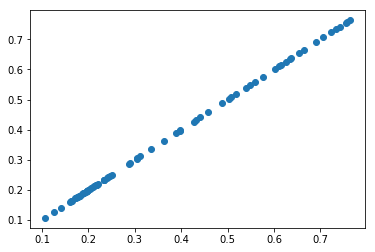

In [238]:
plt.plot(ntcp_hn_imrt,ntcp_hn_imrt1,'o')
plt.show()

In [239]:
test = np.asarray([[np.cumsum(all_d_hn_imrt_array,axis=1)[i][29]] for i in range(len(np.cumsum(all_d_hn_imrt_array,axis=1)))])
test
## want to make this look like the dose array...
test

array([[ 17.083],
       [ 20.935],
       [ 23.403],
       [ 18.691],
       [ 22.207],
       [ 21.024],
       [ 23.194],
       [ 22.101],
       [ 27.421],
       [ 21.733],
       [ 23.649],
       [ 23.874],
       [ 24.453],
       [ 20.669],
       [ 21.923],
       [ 23.024],
       [ 25.094],
       [ 23.971],
       [ 26.728],
       [ 24.66 ],
       [ 22.432],
       [ 22.521],
       [ 23.951],
       [ 25.034],
       [ 26.766],
       [ 23.981],
       [ 25.735],
       [ 26.829],
       [ 27.684],
       [ 25.588],
       [ 24.096],
       [ 25.542],
       [ 27.339],
       [ 25.502],
       [ 30.736],
       [ 30.655],
       [ 28.017],
       [ 35.471],
       [ 32.236],
       [ 31.81 ],
       [ 31.751],
       [ 37.043],
       [ 37.563],
       [ 33.802],
       [ 37.606],
       [ 39.33 ],
       [ 41.138],
       [ 39.696],
       [ 44.649],
       [ 40.167],
       [ 44.04 ],
       [ 43.801],
       [ 46.401],
       [ 42.975],
       [ 47.094],
       [ 4

In [193]:
all_d_hn_imrt_array

array([[ 0.569,  0.579,  0.565, ...,  0.579,  0.576,  0.577],
       [ 0.721,  0.718,  0.721, ...,  0.688,  0.72 ,  0.686],
       [ 0.745,  0.774,  0.762, ...,  0.811,  0.803,  0.775],
       ..., 
       [ 1.956,  1.983,  1.986, ...,  1.909,  1.952,  1.929],
       [ 1.838,  1.903,  1.863, ...,  1.852,  1.839,  1.896],
       [ 1.957,  1.947,  1.995, ...,  1.917,  1.99 ,  2.002]])

In [61]:
ntcp_hn_imrt = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=all_d_array,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)
ntcp_hn_imrt

{'cum_doses': array([[  1.143,   2.287,   3.43 ,   4.573,   5.717,   6.86 ,   8.003,
           9.147,  10.29 ,  11.433,  12.577,  13.72 ,  14.863,  16.007,
          17.15 ,  18.293,  19.437,  20.58 ,  21.723,  22.867,  24.01 ,
          25.153,  26.297,  27.44 ,  28.583,  29.727,  30.87 ,  32.013,
          33.157,  34.3  ,  35.443,  36.587,  37.73 ,  38.873,  40.017,
          41.16 ,  42.303,  43.447,  44.59 ,  45.733],
        [  1.167,   2.333,   3.5  ,   4.667,   5.833,   7.   ,   8.167,
           9.333,  10.5  ,  11.667,  12.833,  14.   ,  15.167,  16.333,
          17.5  ,  18.667,  19.833,  21.   ,  22.167,  23.333,  24.5  ,
          25.667,  26.833,  28.   ,  29.167,  30.333,  31.5  ,  32.667,
          33.833,  35.   ,  36.167,  37.333,  38.5  ,  39.667,  40.833,
          42.   ,  43.167,  44.333,  45.5  ,  46.667],
        [  1.19 ,   2.38 ,   3.57 ,   4.76 ,   5.95 ,   7.14 ,   8.33 ,
           9.52 ,  10.71 ,  11.9  ,  13.09 ,  14.28 ,  15.47 ,  16.66 ,
          17.

# Corrections from here onwards....----------------------------------------------

In [5]:
## Now want to run the model with the fixed parameters for each patient, then return the mean result = the poulaiton NTCP


## get fraction doses for each patient - assume equal dose/# - cumulative dose is all that matters
total_dose_p = 74
frac_dose_p = total_dose_p/37 ## get dose per frac for model

total_dose_hn_imrt = 35 ## mean imrt parotid dose - will be patient specific
frac_dose_hn_imrt = total_dose_hn_imrt/30 ## get dose per frac for model

total_dose_hn_conf = 60 ## mean conf parotid dose - will be patient specific
frac_dose_hn_conf = total_dose_hn_conf/30 ## get dose per frac for model

#print(frac_dose_p)
#print(frac_dose_hn_imrt)
#print(frac_dose_hn_conf)

#*************

## get list of nominal doses for prostate treatments - only the dose parameter values matter
frac_doses_p = model.completeTCPcalc(n=1,
                                      alphabeta_use=1.5,
                                      alphabeta_sd_use=0,
                                      d=frac_dose_p,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=74,
                                      n0 = 74)['doses']

## get list of nominal doses for prostate treatments - only the dose parameter values matter
frac_doses_hn_imrt = model.completeTCPcalc(n=1,
                                      alphabeta_use=1.5,
                                      alphabeta_sd_use=0,
                                      d=frac_dose_hn_imrt,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=35,
                                      n0 = 74)['doses']

## get list of nominal doses for prostate treatments - only the dose parameter values matter
frac_doses_hn_conf = model.completeTCPcalc(n=1,
                                      alphabeta_use=1.5,
                                      alphabeta_sd_use=0,
                                      d=frac_dose_hn_conf,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=60,
                                      n0 = 74)['doses']


## these array of doses can then be manipulated to get teh desired delviered doses for the simulation

#***************

## the below returns nominal NTCP values for nominal doses delviered (based on estimated mean dose values)

## return the NTCP value for this patient
ntcp_rect = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5,0),
                                                    'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                    'm':(0.15,0),
                                                    'n':(0.13,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][36] ## get NTCP after 37#

## return the NTCP value for this patient
ntcp_hn_imrt = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn_imrt,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][29] ## get NTCP after 30#


ntcp_hn_conf = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn_conf,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][29] ## get NTCP after 30#

print('rect',ntcp_rect) ## ideal value = 47%
print('imrt',ntcp_hn_imrt) ## ideal value = 38%
print('conf',ntcp_hn_conf) ##ideal value = 74%



rect 0.597382175553
imrt 0.35474118388
conf 0.76085308702


In [ ]:
#dict_keys(['ntcp_data', 'cum_doses', 'd_data', 'fit_y', 'fit_x', 'td50_1_use', 'pop_fit', 'ntcp_fit', 'patient_ntcps'

In [6]:
## simulate shift in dose by 1%
frac_doses_hn_conf*1.01

array([[ 2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,
         2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,
         2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,
         2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,
         2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,  2.02,
         2.02,  2.02,  2.02,  2.02,  2.02]])

In [7]:
## for h&n conf calc NTCPs for 3 different dose shifts

for i in [0.98,1,1.02]:
    
    the_doses = frac_doses_hn_conf*i
    
    ntcp_hn_conf = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=the_doses,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][29] ## get NTCP after 30#
    print(i,ntcp_hn_conf)

0.98 0.7444521565
1 0.76085308702
1.02 0.776661381004


In [9]:
## convert the above into a function
## specify which set of data to use and return the NTCP value only
## this will save typing the above code each time


def make_dose_array(d,shift=0,num=50):
    shift_val = 1+(shift/100)
    return np.array([[d*shift_val]*num])



def ntcp_val(case,dose_array):
    # case = 'p_rect', 'hn_imrt', or 'hn_conf'
    ## input a dose array
    
    ## select appropriate params for each case
    params = {'p_rect':{'td50_1':(68.5,0),
                        'v': (0.73,0),
                        'm':(0.15,0),
                        'n':(0.13,0)},
             'hn_imrt':{'td50_1':(31.4,0),
                        'v': (0.72,0),
                        'm':(0.53,0),
                        'n':(1,0)},
             'hn_conf':{'td50_1':(31.4,0), # same as imrt case
                        'v': (0.72,0),
                        'm':(0.53,0),
                        'n':(1,0)}
             }
    
    ## select results position - to get result at required fraction
    
    posn = {'p_rect':36,
           'hn_imrt':29,
           'hn_conf':29,
           }
    
    result = model.complete_NTCP_calc(d_data=[64,74],
                                   ntcp_data=[0.36,0.47],
                                   #irrad_perc = 100, ## scaling factor?
                                   frac_doses=dose_array,
                                   max_dose=100,
                                   ntcp_params=params[case],
                                   fit_vals=False,
                                   confirmation=False)['patient_ntcps'][0][posn[case]]
    
    return result

In [ ]:
def make_dose_array_multi(d,shift=0,num=50,pts=2):
    shift_val = 1+(shift/100)
    return np.array([[d*shift_val]*num])

In [26]:
dose_array = make_dose_array(d=2,shift=0)

test = model.complete_NTCP_calc(d_data=[64,74],
                                   ntcp_data=[0.36,0.47],
                                   #irrad_perc = 10, ## scaling factor?
                                   frac_doses=frac_doses_p,
                                   max_dose=100,
                                   ntcp_params={'td50_1':(31.4,0),
                                                'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                'm':(0.53,0),
                                                'n':(1,0)}, #(1,0)
                                   fit_vals=False)['patient_ntcps'][1][29]
test

0.35474118387983755

In [69]:
## generate multiple sets of pateint doses for feeding into NTPC model
## should be quicker than running NTPC model multiple times?
## tcp returns a list of lists as an array.

## need to get multiple tcp dose run with different dose/# into this same format.



pt_frac_dose = 35/30

doses = [1,1,1] ## different dose/# to try

## note different length arrays will be returned due to the max dose. 

all_d = []


frac_doses_p1 = model.completeTCPcalc(n=3,
                                      alphabeta_use=1.5,
                                      alphabeta_sd_use=0,
                                      d=1,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=74,
                                      n0 = 74)['doses']#[0]

for dose in doses:

    frac_doses_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=dose,
                                          d_shift=0, # no shift as start each treatment as if perfect
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74)['doses']#[0]
    #print(frac_doses_p[0])
    all_d.append(list(frac_doses_p[0])) ## compile the results of each
d_results = np.asarray(all_d) ## convert list of lists to an array
d_results

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [75]:
ntcp_hn_conf = model.complete_NTCP_calc(d_data=[64,74],
                                   ntcp_data=[0.36,0.47],
                                   irrad_perc = 100, ## scaling factor?
                                   frac_doses=d_results,
                                   max_dose=100,
                                   ntcp_params={'td50_1':(31.4,0),
                                                'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                'm':(0.53,0),
                                                'n':(1,0)}, #(1,0)
                                   fit_vals=False)['patient_ntcps']#[0][29] ## get NTCP after 30#

for i in range(len(ntcp_hn_conf)):
    print(i)
    print(ntcp_hn_conf[0][29])
#ntcp_hn_conf

0
0.277973728714
1
0.277973728714
2
0.277973728714


In [11]:
## calc NTCP for -2, 0 and +2% dose shifts

for j in [-2,0,2]:
    the_doses = make_dose_array(d=2,shift=j)
    test = ntcp_val('p_rect',the_doses)
    print(j,test)
    

-2 0.543125926877
0 0.597382175553
2 0.649822692493


1 of 74 17.08459707 0.125557795519
2 of 74 20.94980431 0.163439550288
3 of 74 23.38983374 0.190826684588
4 of 74 18.68661924 0.140442368323
5 of 74 22.1926259 0.177054142002
6 of 74 21.03800646 0.164382744308
7 of 74 23.16768571 0.188222627953
8 of 74 22.10487141 0.176069946042
9 of 74 27.42237443 0.241841889243
10 of 74 21.72292308 0.17182671703
11 of 74 23.65160294 0.193923402624
12 of 74 23.88736407 0.196738496977
13 of 74 24.452034 0.203580808496
14 of 74 20.6648406 0.160416350997
15 of 74 21.9181058 0.173986862817
16 of 74 23.03782859 0.186710625889
17 of 74 25.12224576 0.211883546291
18 of 74 23.95218062 0.197516752107
19 of 74 26.72754119 0.232557188887
20 of 74 24.67242991 0.206289473484
21 of 74 22.44765167 0.1799340212
22 of 74 22.52716078 0.18083786004
23 of 74 23.95283694 0.197524642077
24 of 74 25.0362305 0.210807019502
25 of 74 26.7570998 0.2329480864
26 of 74 23.97241953 0.197760142396
27 of 74 25.74338304 0.219752331799
28 of 74 26.83171154 0.233936409891
29 of 74 27.69

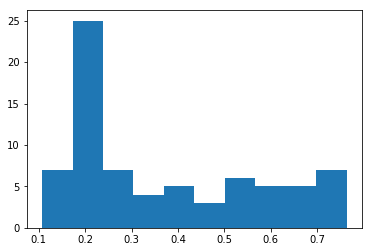

In [12]:
## calc NTCP for all IMRT HN patients - no shift

ntcps = []

i=1
for j in par_imrt:
    count = len(par_imrt)
    the_doses = make_dose_array(d=j/30,shift=0) ## equal dose for each fraction
    test = ntcp_val('hn_imrt',the_doses)
    print(i,'of',count,j,test)
    i=i+1
    
    ntcps.append(test)
print('mean',np.mean(ntcps))
plt.hist(ntcps)
plt.show()

In [236]:
for i in [0.98,1,1.02]:
    
    the_doses = frac_doses_hn_conf*i
    
    ntcp_hn_conf = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=the_doses,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)['patient_ntcps'][0][29] ## get NTCP after 30#
    print(i,ntcp_hn_conf)

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
0.98 0.7444521565
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
1 0.76085308702
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
1.02 0.776661381004


In [3]:
## NPL MV data
## From the NPL Data the SD of the MV beam outputs is 0.7% (section 3.2.1)

## Systematic beam output
## From the first 7 weeks of output data this gives 0.7% also (section 4.3.7.2)

## Daily output fluctuations
## From the farmer chamber 0.2% (section 4.3.8)

npl_err = 0.7
op_err = 0.7
rand_err = 0.2

## convolute the erros together to give combined SDs
print('NPL only SD: ',npl_err)
npl_conv_op = np.sqrt(npl_err**2 + op_err**2)
print('NPL + Output SD: ',npl_conv_op)
npl_conv_op_conv_rand = np.sqrt(npl_err**2 + op_err**2 + rand_err**2)
print('NPL + Output + random SD: ',npl_conv_op_conv_rand)

print('--')
## produce 95% CI
print('NPL only 95%CI: ',npl_err*1.96)
print('NPL + Output 95%CI: ',npl_conv_op*1.96)
print('NPL + Output + random 95%CI: ',npl_conv_op_conv_rand*1.96)

## values to use:
print('--')
print('NPL only 95%CI use: ',1.4)
print('NPL + Output 95%CI use: ',1.9)
print('NPL + Output + random 95%CI use: ',2)

NPL only SD:  0.7
NPL + Output SD:  0.989949493661
NPL + Output + random SD:  1.00995049384
--
NPL only 95%CI:  1.3719999999999999
NPL + Output 95%CI:  1.94030100758
NPL + Output + random 95%CI:  1.97950296792
--
NPL only 95%CI use:  1.4
NPL + Output 95%CI use:  1.9
NPL + Output + random 95%CI use:  2


In [4]:
model.doses_array(n=1,n_frac = 50, d = 2, d_shift=0,d_sd=0,d_trend=0)

array([[ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.]])

In [11]:
## function to get nominal doses and 

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***


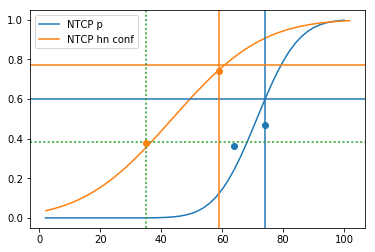

p TCP: 0.597382175553
hn conf TCP: 0.769709984014
hn imrt TCP: 0.38467165398


In [12]:
## use this to get dose array...

## this TCP part is only used to get a list of fraction doses and nominal doses
## this is easiest as the dose variaiotn is builtin.
TCP_results_p = model.completeTCPcalc(n=1,
                                      alphabeta_use=1.5,
                                      alphabeta_sd_use=0,
                                      d=2,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=74,
                                      n0 = 74) ##*********

TCP_results_hn = model.completeTCPcalc(n=1,
                                      alphabeta_use=10,
                                      alphabeta_sd_use=0,
                                      d=65/30,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=59,
                                      n0 = 3000000) ##*********


frac_doses_p = TCP_results_p['doses']
nom_doses_p = TCP_results_p['nom_doses']
frac_doses_hn = TCP_results_hn['doses']
nom_doses_hn = TCP_results_hn['nom_doses']

## v is manually determined based ont he TCP/dose points

NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5,0),
                                                    'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.15,0),
                                                    'n':(0.13,0)}, #(1,0)
                                       fit_vals=False)

NTCP_results_hn = model.complete_NTCP_calc(d_data=[35,59],
                                       ntcp_data=[0.38,0.74],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0) ## this was fitted based on the data points
                                       fit_vals=False)

plt.plot(nom_doses_p,NTCP_results_p['patient_ntcps'][0],label='NTCP p')
plt.plot(nom_doses_hn,NTCP_results_hn['patient_ntcps'][0],label='NTCP hn conf')
## show dose of interest point
plt.axvline(74,c=color_p)
plt.axhline(NTCP_results_p['patient_ntcps'][0][36],c=color_p)
plt.axvline(59,c=color_hn_conf)
plt.axhline(NTCP_results_hn['patient_ntcps'][0][27],c=color_hn_conf)
plt.axvline(35,c=color_hn_imrt,ls=':')
plt.axhline(NTCP_results_hn['patient_ntcps'][0][16],c=color_hn_imrt,ls=':')

## show dose points
plt.plot(NTCP_results_p['d_data'],NTCP_results_p['ntcp_data'],'o',c=color_p)
plt.plot(NTCP_results_hn['d_data'],NTCP_results_hn['ntcp_data'],'o',c=color_hn_conf)


plt.legend()
plt.show()

## get TCP at doses of interest.

print('p TCP:',NTCP_results_p['patient_ntcps'][0][36])
print('hn conf TCP:',NTCP_results_hn['patient_ntcps'][0][27])
print('hn imrt TCP:',NTCP_results_hn['patient_ntcps'][0][16])

In [13]:
## have three doses of interest on these curves:
## HN_imrt = 35Gy [pos 16](mean IMRT dose to parotids)
## HN_conf = 59Gy [pos27](mean conformal dose to parotids) [gradient of NTCP for IMRT and conf doses is actually quite similar.]
## Prostate = 74Gy [pos36]

In [14]:
## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ** this is the format required for analysis the dose variaiton.

## ************ d_dif **********

d_dif_res = {}

for d_dif in [0,1]: ## vary the dose by this amount (%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=d_dif,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=d_dif, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    d_dif_res[d_dif] = {'prost':NTCP_results_p['patient_ntcps'][0][36],
                       'hn conf':NTCP_results_hn['patient_ntcps'][0][27],
                       'hn imrt':NTCP_results_hn['patient_ntcps'][0][16]} ## get the result at teh required dose points


for i in sorted(d_dif_res):
    print(i,d_dif_res[i])
    
cases_d = {}

for case in d_dif_res[0]: ## loop each clinical case
    #print(case)
    orig = d_dif_res[0][case] ## 0% change
    new = d_dif_res[1][case] ## 1% change
    perc_dif = ((new/orig)-1)*100
    print(case,round(orig,3),round(new,3),round(perc_dif,3))
    cases_d[case] = perc_dif

print('')
    
print('% dif cased by 1% increase in change of dose')
print(cases_d)

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
0 {'hn imrt': 0.3846716539795782, 'hn conf': 0.76970998401427049, 'prost': 0.59738217555305362}
1 {'hn imrt': 0.39077549338584966, 'hn conf': 0.77760777117152124, 'prost': 0.62388844725191528}
hn imrt 0.385 0.391 1.587
hn conf 0.77 0.778 1.026
prost 0.597 0.624 4.437

% dif cased by 1% increase in change of dose
{'hn imrt': 1.5867661011995216, 'hn conf': 1.0260731082194718, 'prost': 4.4370710716840955}


In [15]:
## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ************ m **********

m_dif_res = {}

for m_dif in [1,1.01]: ## vary the dose by this factor (0 and 1%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=0,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=0, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15*m_dif,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53*m_dif,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    m_dif_res[m_dif] = {'prost':NTCP_results_p['patient_ntcps'][0][36],
                       'hn conf':NTCP_results_hn['patient_ntcps'][0][27],
                       'hn imrt':NTCP_results_hn['patient_ntcps'][0][16]} ## get the result at teh required dose points


for i in sorted(m_dif_res):
    print(i,m_dif_res[i])
    
cases_m = {}

for case in m_dif_res[1]: ## loop each clinical case
    #print(case)
    orig = m_dif_res[1][case] ## 0% change
    new = m_dif_res[1.01][case] ## 1% change
    perc_dif = ((new/orig)-1)*100
    print(case,round(orig,3),round(new,3),round(perc_dif,3))
    cases_m[case] = perc_dif

print('')
    
print('% dif cased by 1% increase in change of m')
print(cases_m)

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
1 {'hn imrt': 0.3846716539795782, 'hn conf': 0.76970998401427049, 'prost': 0.59738217555305362}
1.01 {'hn imrt': 0.38578163513947167, 'hn conf': 0.76748403367754781, 'prost': 0.59643709492771835}
hn imrt 0.385 0.386 0.289
hn conf 0.77 0.767 -0.289
prost 0.597 0.596 -0.158

% dif cased by 1% increase in change of m
{'hn imrt': 0.28855288618494512, 'hn conf': -0.2891933823066295, 'prost': -0.15820368668688634}


In [16]:
## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ************ n **********

n_dif_res = {}

for n_dif in [1,0.99]: ## vary the dose by this factor (0 and 1%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=0,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=0, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13*n_dif,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1.0*n_dif,0)}, #(1,0)
                                           fit_vals=False)
    
    n_dif_res[n_dif] = {'prost':NTCP_results_p['patient_ntcps'][0][36],
                       'hn conf':NTCP_results_hn['patient_ntcps'][0][27],
                       'hn imrt':NTCP_results_hn['patient_ntcps'][0][16]} ## get the result at teh required dose points


for i in sorted(n_dif_res):
    print(i,n_dif_res[i])
    
cases_n = {}

for case in n_dif_res[1]: ## loop each clinical case
    #print(case)
    orig = n_dif_res[1][case] ## 0% change
    new = n_dif_res[0.99][case] ## 1% change
    perc_dif = -((new/orig)-1)*100
    print(case,round(orig,3),round(new,3),round(perc_dif,3))
    cases_n[case] = perc_dif

print('')
    
print('% dif cased by 1% *decrease* in change of n - swapped sign...')
#print('note n is held fixed for H&N at 1, hence the decrease used as n is limited between 0-1')
print(cases_n)

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
0.99 {'hn imrt': 0.38667701525324244, 'hn conf': 0.77232587495696725, 'prost': 0.59847658808456272}
1 {'hn imrt': 0.3846716539795782, 'hn conf': 0.76970998401427049, 'prost': 0.59738217555305362}
hn imrt 0.385 0.387 -0.521
hn conf 0.77 0.772 -0.34
prost 0.597 0.598 -0.183

% dif cased by 1% *decrease* in change of n - swapped sign...
{'hn imrt': -0.52131766219787323, 'hn conf': -0.33985410050862974, 'prost': -0.18320140377403593}


In [17]:
## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ************ v **********

v_dif_res = {}

for v_dif in [1,1.01]: ## vary the dose by this factor (0 and 1%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=0,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=0, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73*v_dif,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72*v_dif,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    v_dif_res[v_dif] = {'prost':NTCP_results_p['patient_ntcps'][0][36],
                       'hn conf':NTCP_results_hn['patient_ntcps'][0][27],
                       'hn imrt':NTCP_results_hn['patient_ntcps'][0][16]} ## get the result at teh required dose points


for i in sorted(v_dif_res):
    print(i,v_dif_res[i])
    
cases_v = {}

for case in v_dif_res[1]: ## loop each clinical case
    #print(case)
    orig = v_dif_res[1][case] ## 0% change
    new = v_dif_res[1.01][case] ## 1% change
    perc_dif = ((new/orig)-1)*100
    print(case,round(orig,3),round(new,3),round(perc_dif,3))
    cases_v[case] = perc_dif

print('')
    
print('% dif cased by 1% increase in change of v')
print(cases_v)

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
1 {'hn imrt': 0.3846716539795782, 'hn conf': 0.76970998401427049, 'prost': 0.59738217555305362}
1.01 {'hn imrt': 0.39077549338584994, 'hn conf': 0.77760777117152113, 'prost': 0.60084130086589427}
hn imrt 0.385 0.391 1.587
hn conf 0.77 0.778 1.026
prost 0.597 0.601 0.579

% dif cased by 1% increase in change of v
{'hn imrt': 1.5867661011995882, 'hn conf': 1.0260731082194496, 'prost': 0.579047292403434}


In [18]:
all_sens = {'d':cases_d,
           'v':cases_v,
           'm':cases_m,
           'n':cases_n}
all_sens

{'d': {'hn conf': 1.0260731082194718,
  'hn imrt': 1.5867661011995216,
  'prost': 4.4370710716840955},
 'm': {'hn conf': -0.2891933823066295,
  'hn imrt': 0.28855288618494512,
  'prost': -0.15820368668688634},
 'n': {'hn conf': -0.33985410050862974,
  'hn imrt': -0.52131766219787323,
  'prost': -0.18320140377403593},
 'v': {'hn conf': 1.0260731082194496,
  'hn imrt': 1.5867661011995882,
  'prost': 0.579047292403434}}

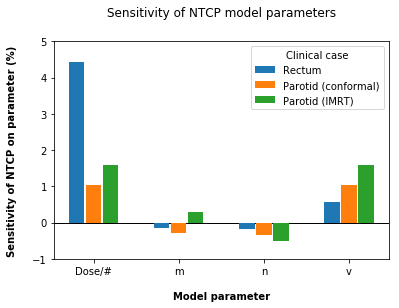

In [19]:
## create barplot of results
the_params = ['d','m','n','v']
the_tick_labels = ['Dose/#','m','n','v']

p_vals = [all_sens[i]['prost'] for i in the_params] ## rectum vals
hn_conf_vals = [all_sens[i]['hn conf'] for i in the_params] ## parotid conformal
hn_imrt_vals = [all_sens[i]['hn imrt'] for i in the_params] ## parotid imrt

offset = 0.2
width = 0.18
plt.bar(left=[0-offset,1-offset,2-offset,3-offset],height=p_vals,width=width,label='Rectum')
plt.bar(left=[0,1,2,3],height=hn_conf_vals,width=width,label='Parotid (conformal)')
plt.bar(left=[0+offset,1+offset,2+offset,3+offset],height=hn_imrt_vals,width=width,label='Parotid (IMRT)')
plt.axhline(0,c='black',lw=1,zorder=0)
plt.ylabel('Sensitivity of NTCP on parameter (%)')
plt.xlabel('Model parameter')
plt.xticks([0,1,2,3],the_tick_labels)
plt.ylim(-1,5)
plt.title('Sensitivity of NTCP model parameters')

plt.legend(title='Clinical case')
#plt.savefig('NTCP_sensitivity.png',dpi=300,bbox_inches='tight')
plt.show()
## this plot is reversed to what I want.. TNeed to swap x axis and legend around... 

# Different variations in dose.
- Systematic  + Random
- Quantified to match the TCP analysis

## known systematic dose difference
- Known beam output - model single 'typical' patient with different beam outputs.
- Collate the NTCP for each case and plot NTCP dif (%) vs dose dif (%)

In [20]:
## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ** this is the format required for analysis the dose variaiton.

## ************ d_dif **********

## store each set of results.
p_res = {}
hn_conf_res = {}
hn_imrt_res = {}

#d_difs = [-2,-1,0,1,2,3]
d_difs = np.arange(-5,5,0.25)

for d_dif in d_difs: ## vary the dose by this amount (%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=d_dif,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=d_dif, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    p_res[d_dif] = NTCP_results_p['patient_ntcps'][0][36]
    hn_conf_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][27]
    hn_imrt_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][16]## get the result at the required dose points


Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***

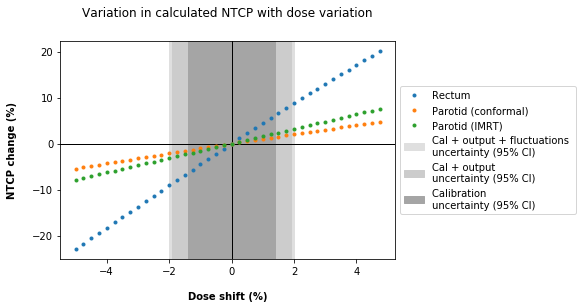

shift -5.0 rectum -22.91 parotid conf -5.42 parotid imrt -7.82
shift -4.75 rectum -21.76 parotid conf -5.14 parotid imrt -7.43
shift -4.5 rectum -20.61 parotid conf -4.86 parotid imrt -7.04
shift -4.25 rectum -19.45 parotid conf -4.58 parotid imrt -6.66
shift -4.0 rectum -18.3 parotid conf -4.3 parotid imrt -6.27
shift -3.75 rectum -17.15 parotid conf -4.02 parotid imrt -5.88
shift -3.5 rectum -15.99 parotid conf -3.75 parotid imrt -5.49
shift -3.25 rectum -14.84 parotid conf -3.47 parotid imrt -5.1
shift -3.0 rectum -13.69 parotid conf -3.2 parotid imrt -4.71
shift -2.75 rectum -12.53 parotid conf -2.92 parotid imrt -4.32
shift -2.5 rectum -11.38 parotid conf -2.65 parotid imrt -3.93
shift -2.25 rectum -10.23 parotid conf -2.38 parotid imrt -3.54
shift -2.0 rectum -9.08 parotid conf -2.11 parotid imrt -3.15
shift -1.75 rectum -7.94 parotid conf -1.84 parotid imrt -2.76
shift -1.5 rectum -6.79 parotid conf -1.58 parotid imrt -2.37
shift -1.25 rectum -5.65 parotid conf -1.31 parotid imr

In [21]:

## get percentage difference results
p_perc = []
hn_conf_perc = []
hn_imrt_perc = []

for d in d_difs:
    p_orig = p_res[0]
    p_d = p_res[d]
    p_dif = ((p_d/p_orig)-1)*100
    p_perc.append(p_dif)
    
    hn_conf_orig = hn_conf_res[0]
    hn_conf_d = hn_conf_res[d]
    hn_conf_dif = ((hn_conf_d/hn_conf_orig)-1)*100
    hn_conf_perc.append(hn_conf_dif)
    
    hn_imrt_orig = hn_imrt_res[0]
    hn_imrt_d = hn_imrt_res[d]
    hn_imrt_dif = ((hn_imrt_d/hn_imrt_orig)-1)*100
    hn_imrt_perc.append(hn_imrt_dif)
    
plt.plot(d_difs,p_perc,'o',c=color_p,label='Rectum',ms=3)
plt.plot(d_difs,hn_conf_perc,'o',c=color_hn_conf,label='Parotid (conformal)',ms=3)
plt.plot(d_difs,hn_imrt_perc,'o',c=color_hn_imrt,label='Parotid (IMRT)',ms=3)

plt.axhline(0,color='black',lw=1,zorder=0)
plt.axvline(0,color='black',lw=1,zorder=0)

plt.xlabel('Dose shift (%)')
plt.ylabel('NTCP change (%)')
plt.title('Variation in calculated NTCP with dose variation')


## shade the regions of interest with different colours and labels
output_errors = {1.4:{'label':'Calibration \nuncertainty (95% CI)',
                    'color':'#a5a5a5'},
                 1.9:{'label':'Cal + output \nuncertainty (95% CI)',
                   'color':'#cccccc'},
                2:{'label':'Cal + output + fluctuations \nuncertainty (95% CI)',
                   'color':'#dfdfdf'}}

for val in sorted(output_errors,reverse=True):
    plt.axvspan(-val,val,alpha=1,color=output_errors[val]['color'],zorder=0,label=output_errors[val]['label'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('NTCP-systematic_dose_dif.png',dpi=300,bbox_inches='tight')

plt.show()
## show the numerical results
for i in range(len(d_difs)):
    print('shift',d_difs[i],'rectum',round(p_perc[i],2),'parotid conf',round(hn_conf_perc[i],2),'parotid imrt',round(hn_imrt_perc[i],2))

## Variation due to machine scheduling.
- Create plot of NTCPs with 95% CI shaded.
- 100 patients on machines with dose with SD of 1.0% = combined machine and beam cal SD.

In [62]:
## this takes a while...

## generate 1000 random dose deviaitons from normal distribution
the_n = 1000 ##1000 used for final thing
the_sd = 0.4
the_mean = 0
dose_shifts = np.random.normal(loc=the_mean,scale=the_sd,size=the_n)

## need to get parameter sensitivity for each situation at the doses of interest
## params = v, m, n, d(daily dose == equivalent to cumulative dose in % terms)

## ** this is the format required for analysis the dose variaiton.

## ************ d_dif **********

## store each set of results.
p_res = {}
hn_conf_res = {}
hn_imrt_res = {}

ntcp_p_res = []
ntcp_hn_res = []
i=0

for d_dif in dose_shifts: ## vary the dose by this amount (%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=d_dif,
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=d_dif, 
                                          d_sd=0,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    #print(frac_doses_p)
    #print(NTCP_results_p['patient_ntcps'][0])
    p_res[d_dif] = NTCP_results_p['patient_ntcps'][0][36]
    hn_conf_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][27]
    hn_imrt_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][16]## get the result at the required dose points
    
    ntcp_p_res.append(NTCP_results_p['patient_ntcps'][0])
    ntcp_hn_res.append(NTCP_results_hn['patient_ntcps'][0])
    i=i+1
    print(i)
    
#plt.show()

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
1
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
2
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
3
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
4
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
5
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
6
Calculating Individual Patient NTCP curves
*** NTCP Simulation C

In [63]:
all_data = {'p':ntcp_p_res,
           'hn':ntcp_hn_res}
save_pkl(all_data,'ntcp_machine_assign_04perc.pkl')

ntcp_mach_1perc = load_pkl('ntcp_machine_assign_1perc.pkl')
ntcp_mach_08perc = load_pkl('ntcp_machine_assign_08perc.pkl')
ntcp_mach_04perc = load_pkl('ntcp_machine_assign_04perc.pkl')

## these data items contain NTCP results for 1000 patients.
## 1perc is for NPL + OP
## 08perc is for NPL only.
## 04perc is NPL most recent value
## can use these to get boxplots of NTPC var at specific points.

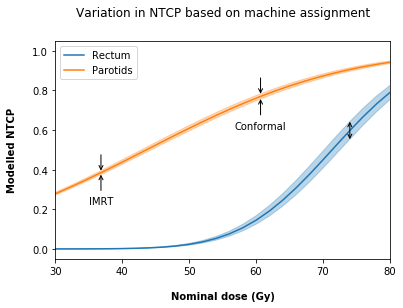

In [104]:
## create a plot with prost and HN data. Add arrows at the doses of interest.

ntcp_p_mean = np.mean(ntcp_mach_1perc['p'],axis=0)
ntcp_p_5perc = np.percentile(ntcp_mach_1perc['p'],5,axis=0)
ntcp_p_95perc = np.percentile(ntcp_mach_1perc['p'],95,axis=0)

plt.plot(nom_doses_p,ntcp_p_mean,label='Rectum')
plt.fill_between(nom_doses_p,ntcp_p_5perc,ntcp_p_95perc,
                color=color_p,zorder=0,alpha=0.3)

ntcp_hn_mean = np.mean(ntcp_mach_1perc['hn'],axis=0)
ntcp_hn_5perc = np.percentile(ntcp_mach_1perc['hn'],5,axis=0)
ntcp_hn_95perc = np.percentile(ntcp_mach_1perc['hn'],95,axis=0)

plt.plot(nom_doses_hn,ntcp_hn_mean,label='Parotids')
plt.fill_between(nom_doses_hn,ntcp_hn_5perc,ntcp_hn_95perc,
                color=color_hn_conf,zorder=0,alpha=0.3)

plt.xlim(30,80)
plt.legend()

## show range of interest with arrows
## use annotate with no text as it seems easier
### rectum
plt.annotate(s='', xy=(74,ntcp_p_5perc[36]), xytext=(74,ntcp_p_95perc[36]),
             arrowprops=dict(arrowstyle='<->',
                             shrinkA=0, shrinkB=0,
                             alpha=1))

## parotid_conformal (dose is rounded to nearest fraction - posn 27 = #28)
plt.annotate(s='', xy=(28*65/30,ntcp_hn_5perc[27]-0.08), xytext=(28*65/30,ntcp_hn_5perc[27]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))
plt.annotate(s='', xy=(28*65/30,ntcp_hn_95perc[27]+0.08), xytext=(28*65/30,ntcp_hn_95perc[27]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))

## parotid_IMRT (dose is rounded to nearest fraction - posn 16 = #17)
plt.annotate(s='', xy=(17*65/30,ntcp_hn_5perc[16]-0.08), xytext=(17*65/30,ntcp_hn_5perc[16]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))
plt.annotate(s='', xy=(17*65/30,ntcp_hn_95perc[16]+0.08), xytext=(17*65/30,ntcp_hn_95perc[16]),
             arrowprops=dict(arrowstyle='<-',
                             shrinkA=0, shrinkB=0,
                             alpha=1))

plt.text(17*65/30,ntcp_hn_5perc[16]-0.15,'IMRT',horizontalalignment='center')
plt.text(28*65/30,ntcp_hn_5perc[27]-0.15,'Conformal',horizontalalignment='center')

plt.xlabel('Nominal dose (Gy)')
plt.ylabel('Modelled NTCP')
plt.title('Variation in NTCP based on machine assignment')

#plt.savefig('ntcp_95CI-p+hn.png',dpi=300,bbox_inches='tight')

plt.show()

In [66]:
## Now want to take the above results, 
## get the NTCP at the dose of interest and plot these as boxplots.

ntcp_p_d_int_npl_04 = []
ntcp_hn_conf_d_int_npl_04 = []
ntcp_hn_imrt_d_int_npl_04 = []

ntcp_p_d_int_npl = []
ntcp_hn_conf_d_int_npl = []
ntcp_hn_imrt_d_int_npl = []

ntcp_p_d_int_npl_op = []
ntcp_hn_conf_d_int_npl_op = []
ntcp_hn_imrt_d_int_npl_op = []

## get rectum stuff
for i in range(len(ntcp_mach_04perc['p'])):
    ntcp_p_d_int_npl_04.append(((ntcp_mach_04perc['p'][i][36]/np.mean(ntcp_mach_04perc['p'],axis=0)[36])-1)*100)

for i in range(len(ntcp_mach_08perc['p'])):
    ntcp_p_d_int_npl.append(((ntcp_mach_08perc['p'][i][36]/np.mean(ntcp_mach_08perc['p'],axis=0)[36])-1)*100)

for i in range(len(ntcp_mach_1perc['p'])):
    ntcp_p_d_int_npl_op.append(((ntcp_mach_1perc['p'][i][36]/np.mean(ntcp_mach_1perc['p'],axis=0)[36])-1)*100)

## get hn conf stuff
for i in range(len(ntcp_mach_04perc['hn'])):
    ntcp_hn_conf_d_int_npl_04.append(((ntcp_mach_04perc['hn'][i][27]/np.mean(ntcp_mach_04perc['hn'],axis=0)[27])-1)*100)

for i in range(len(ntcp_mach_08perc['hn'])):
    ntcp_hn_conf_d_int_npl.append(((ntcp_mach_08perc['hn'][i][27]/np.mean(ntcp_mach_08perc['hn'],axis=0)[27])-1)*100)

for i in range(len(ntcp_mach_1perc['hn'])):
    ntcp_hn_conf_d_int_npl_op.append(((ntcp_mach_1perc['hn'][i][27]/np.mean(ntcp_mach_1perc['hn'],axis=0)[27])-1)*100)

## get hn imrt stuff
for i in range(len(ntcp_mach_04perc['hn'])):
    ntcp_hn_imrt_d_int_npl_04.append(((ntcp_mach_04perc['hn'][i][16]/np.mean(ntcp_mach_04perc['hn'],axis=0)[16])-1)*100)

for i in range(len(ntcp_mach_08perc['hn'])):
    ntcp_hn_imrt_d_int_npl.append(((ntcp_mach_08perc['hn'][i][16]/np.mean(ntcp_mach_08perc['hn'],axis=0)[16])-1)*100)

for i in range(len(ntcp_mach_1perc['hn'])):
    ntcp_hn_imrt_d_int_npl_op.append(((ntcp_mach_1perc['hn'][i][16]/np.mean(ntcp_mach_1perc['hn'],axis=0)[16])-1)*100)


NPL 04 sds
1.72430988109
0.399148209123
0.610163100153
NPL sds
3.54341225834
0.820711693352
1.25442851755
NPL + OP sds
4.4346160286
1.02820162416
1.57254385028


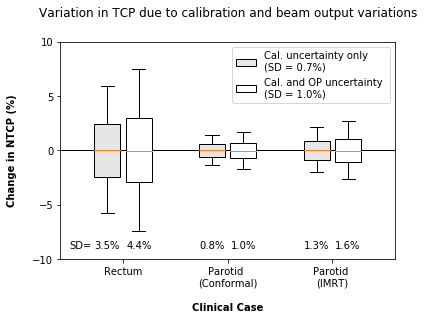

In [68]:
## plot it

ntcp_box_npl_04 = [ntcp_p_d_int_npl_04,ntcp_hn_conf_d_int_npl_04,ntcp_hn_imrt_d_int_npl_04]
ntcp_box_npl = [ntcp_p_d_int_npl,ntcp_hn_conf_d_int_npl,ntcp_hn_imrt_d_int_npl]
ntcp_box_npl_op = [ntcp_p_d_int_npl_op,ntcp_hn_conf_d_int_npl_op,ntcp_hn_imrt_d_int_npl_op]

print('NPL 04 sds')
for i in ntcp_box_npl_04:
    print(np.std(i))
print('NPL sds')
for i in ntcp_box_npl:
    print(np.std(i))
print('NPL + OP sds')
for i in ntcp_box_npl_op:
    print(np.std(i))

offset = 0.15
width = 0.25

fig, ax = plt.subplots()

bp1=plt.boxplot(ntcp_box_npl,vert=True,widths=width,whis=[5,95],sym='',showmeans=False,
           positions=[1-offset,2-offset,3-offset], patch_artist=True,boxprops={'facecolor':'#E6E6E6','alpha':1,'edgecolor':'black'})

bp2=plt.boxplot(ntcp_box_npl_op,vert=True,widths=width,whis=[5,95],sym='',showmeans=False,
           positions=[1+offset,2+offset,3+offset], patch_artist=True,boxprops={'facecolor':'white','alpha':1,'edgecolor':'black'})

plt.xticks([1,2,3],['Rectum','Parotid \n(Conformal)', 'Parotid \n(IMRT)'])

plt.title('Variation in TCP due to calibration and beam output variations')
plt.xlabel('Clinical Case')
plt.ylabel('Change in NTCP (%)')

plt.axhline(0,color='black',lw=1,zorder=0)

ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Cal. uncertainty only \n(SD = 0.7%)', 'Cal. and OP uncertainty \n(SD = 1.0%)'])

text_x = [0.85,1.85,2.85,1.15,2.15,3.15] ## manually set

the_sds = []
for i in ntcp_box_npl:
    the_sds.append(np.std(i))
for i in ntcp_box_npl_op:
    the_sds.append(np.std(i))

for i in range(len(text_x)):
    plt.text(text_x[i],-9,str(round(the_sds[i],1))+'%',horizontalalignment='center')

plt.text(0.7,-9,'SD=',horizontalalignment='right')

plt.ylim(-10,10)
plt.xlim(0.4,3.6)

plt.yticks([-10,-5,0,5,10])

#plt.savefig('ntcp_npl_op_boxplot.png',dpi=300,bbox_inches='tight')

plt.show()

## Annual drift
- Range =-10 to +10 - get NTCP at each of the dose points
- shaded range = -3.5 to +5.3 = 95% CI of drifts (%/yr)

In [8]:
## ************ dose drift **********

## store each set of results.
p_res = {}
hn_conf_res = {}
hn_imrt_res = {}

d_drifts = np.linspace(-10,10,41) ## every 0.5%

for d_dif in d_drifts: ## vary the dose by this amount (%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=0,
                                          d_sd=0,
                                          d_trend=d_dif/365, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=0, 
                                          d_sd=0,
                                          d_trend=d_dif/365, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    p_res[d_dif] = NTCP_results_p['patient_ntcps'][0][36]
    hn_conf_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][27]
    hn_imrt_res[d_dif] = NTCP_results_hn['patient_ntcps'][0][16]## get the result at the required dose points






Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***

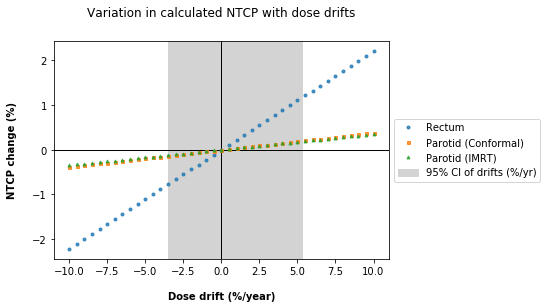

In [16]:
## calcualte % change in NTCPs

drift_perc = []
drift_p_perc = []
drift_hn_conf_perc = []
drift_hn_imrt_perc = []

for i in sorted(p_res.keys()):
    
    drift_perc.append(i)
    drift_p_perc.append(((p_res[i]/p_res[0])-1)*100)
    drift_hn_conf_perc.append(((hn_conf_res[i]/hn_conf_res[0])-1)*100)
    drift_hn_imrt_perc.append(((hn_imrt_res[i]/hn_imrt_res[0])-1)*100)
    
## plot results
plt.plot(drift_perc,drift_p_perc,'o',ms=3,color=color_p,label='Rectum',alpha=0.8)
plt.plot(drift_perc,drift_hn_conf_perc,'s',ms=3,color=color_hn_conf,label='Parotid (Conformal)',alpha=0.8)
plt.plot(drift_perc,drift_hn_imrt_perc,'^',ms=3,color=color_hn_imrt,label='Parotid (IMRT)',alpha=0.8)

plt.axvline(0,color='black',lw=1,zorder=0)
plt.axhline(0,color='black',lw=1,zorder=0)
## shade the regions of interest with different colours and labels
plt.axvspan(-3.5,5.3,alpha=1,color='lightgrey',zorder=0,label='95% CI of drifts (%/yr)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Dose drift (%/year)')
plt.ylabel('NTCP change (%)')
plt.title('Variation in calculated NTCP with dose drifts')

#plt.savefig('NTCP-dose_drift_var.png',dpi=300,bbox_inches='tight')

plt.show()

## Impact of (daily) dose SD on NTCP SD
- Range of dose SDs from 0 - 2% (every 0.1%)
- Measure SD of NTCP at the dose points for each case.
- Can use built-in multi patient fucitons of models.
    - Use n=1000

In [46]:
d_sds = np.linspace(start = 0,stop = 2,num = 21,endpoint=True)
#d_sds = [0,1,2]
p_sd_res = {}
hn_conf_sd_res = {}
hn_imrt_sd_res = {}


for d_dif in d_sds: ## vary the dose by this amount (%)

    ##**************************************************************************************

    ## this TCP part is only used to get a list of fraction doses and nominal doses
    ## this is easiest as the dose variation is builtin. Then just get the required results to use in NTCP.
    TCP_results_p = model.completeTCPcalc(n=1000,
                                          alphabeta_use=1.5,
                                          alphabeta_sd_use=0,
                                          d=2,
                                          d_shift=0,
                                          d_sd=d_dif,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=74,
                                          n0 = 74) ##*********

    TCP_results_hn = model.completeTCPcalc(n=1000,
                                          alphabeta_use=10,
                                          alphabeta_sd_use=0,
                                          d=65/30,
                                          d_shift=0, 
                                          d_sd=d_dif,
                                          d_trend=0, # vary the trend value
                                          max_d=100,
                                          dose_of_interest=59,
                                          n0 = 3000000) ##*********

    ## use these in the NTCP calcs.
    frac_doses_p = TCP_results_p['doses']
    nom_doses_p = TCP_results_p['nom_doses']
    frac_doses_hn = TCP_results_hn['doses']
    nom_doses_hn = TCP_results_hn['nom_doses']

    ##**************************************************************************************

    ## calc NTCP perc dif: TD50
    NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                           ntcp_data=[0.36,0.47],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_p,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(68.5,0),
                                                        'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.15,0),
                                                        'n':(0.13,0)}, #(1,0)
                                           fit_vals=False)

    NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                           ntcp_data=[0.66],
                                           irrad_perc = 100, ## scaling factor?
                                           frac_doses=frac_doses_hn,
                                           max_dose=100,
                                           ntcp_params={'td50_1':(31.4,0),
                                                        'v': (0.72,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                        'm':(0.53,0),
                                                        'n':(1,0)}, #(1,0)
                                           fit_vals=False)
    
    p_sd_res[d_dif] = NTCP_results_p['patient_ntcps'] ## save entire NTCP curves
    hn_conf_sd_res[d_dif] = NTCP_results_hn['patient_ntcps']
    hn_imrt_sd_res[d_dif] = NTCP_results_hn['patient_ntcps']

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***

In [48]:
#save_pkl(p_sd_res,'NTCP_p_res_dailySD.pkl')
#save_pkl(hn_conf_sd_res,'NTCP_hn_conf_res_dailySD.pkl')
#save_pkl(hn_imrt_sd_res,'NTCP_hn_imrt_res_dailySD.pkl')

p_res = load_pkl('NTCP_p_res_dailySD.pkl')
hn_conf_res = load_pkl('NTCP_hn_conf_res_dailySD.pkl')
hn_imrt_res = load_pkl('NTCP_hn_imrt_res_dailySD.pkl')

0.0 0.0 0.0 0.0
0.1 0.07 0.02 0.04
0.2 0.15 0.04 0.08
0.3 0.22 0.06 0.12
0.4 0.3 0.08 0.16
0.5 0.37 0.1 0.19
0.6 0.45 0.11 0.22
0.7 0.52 0.14 0.28
0.8 0.58 0.15 0.3
0.9 0.67 0.18 0.34
1.0 0.72 0.2 0.39
1.1 0.83 0.21 0.4
1.2 0.88 0.24 0.48
1.3 0.93 0.25 0.49
1.4 0.97 0.27 0.52
1.5 1.06 0.3 0.58
1.6 1.2 0.31 0.61
1.7 1.32 0.33 0.62
1.8 1.31 0.35 0.69
1.9 1.42 0.37 0.72
2.0 1.54 0.41 0.79


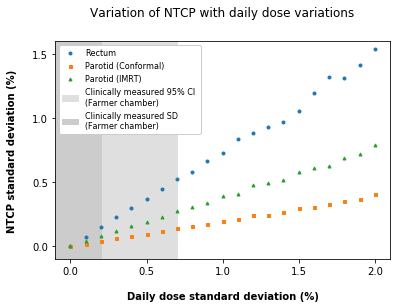

In [61]:
## get the NTCP values at each required dose point and get SD

dose_sds = []
p_sd_percs = []
hn_conf_sd_percs = []
hn_imrt_sd_percs = []
for i in sorted(p_res.keys()):
    dose_sds.append(i)
    p_sd_percs.append(100*np.std(p_res[i],axis=0)[36]/np.mean(p_res[i],axis=0)[36])
    hn_conf_sd_percs.append(100*np.std(hn_conf_res[i],axis=0)[27]/np.mean(hn_conf_res[i],axis=0)[27])
    hn_imrt_sd_percs.append(100*np.std(hn_imrt_res[i],axis=0)[16]/np.mean(hn_imrt_res[i],axis=0)[16])
    print(i,
         round(100*np.std(p_res[i],axis=0)[36]/np.mean(p_res[i],axis=0)[36],2),
         round(100*np.std(hn_conf_res[i],axis=0)[27]/np.mean(hn_conf_res[i],axis=0)[27],2),
         round(100*np.std(hn_imrt_res[i],axis=0)[16]/np.mean(hn_imrt_res[i],axis=0)[16],2))

    
## create plot

plt.plot(dose_sds,p_sd_percs,'o',color=color_p,ms=3,label='Rectum')
plt.plot(dose_sds,hn_conf_sd_percs,'s',color=color_hn_conf,ms=3,label='Parotid (Conformal)')
plt.plot(dose_sds,hn_imrt_sd_percs,'^',color=color_hn_imrt,ms=3,label='Parotid (IMRT)')


plt.axvspan(-1,0.7,alpha=1,color='#dfdfdf',zorder=0,label='Clinically measured 95% CI \n(Farmer chamber)')
plt.axvspan(-1,0.2,alpha=1,color='#cccccc',zorder=0,label='Clinically measured SD \n(Farmer chamber)')


leg = plt.legend(loc='upper left',fontsize=8)
leg.get_frame().set_alpha(1)

plt.xlim(-0.1,2.1)
plt.xticks([0,0.5,1,1.5,2])
plt.ylim(-0.1,1.6)
plt.yticks([0,0.5,1,1.5])


plt.title('Variation of NTCP with daily dose variations')
plt.ylabel('NTCP standard deviation (%)')
plt.xlabel('Daily dose standard deviation (%)')

#plt.savefig('NTCP_daily_dose_SD.png',dpi=300,bbox_inches='tight')
plt.show()

In [41]:
## SD at required dose in %
p_sd_perc = np.std(p_res[1],axis=0)[36]
## mean at required dose so can calc SD at percent
np.mean(p_res[1],axis=0)[36]

0.59679346635765373

## Change from 0.8% to 0.4% SD in beam calibration
- Get the NTCP variation (SD) for eahc case with a set of beam with 0.8% and 0.4% SD.
- This is done usign the 'machine scheduling' method.
    - A new set of 0.4% deviation was created.